# Table des matières

### [Importations](#T1)
- [Importing packages](#T1C1)
- [Importing food data](#T1C2)
- [Reducing food data size](#T1C3)


### [Overview of the data and cleaning up](#T2)
- [Overview of the data](#T2C1)
- [Idée d'application nutritionnelle](#T2C2)
- [dtypes](#T2C3)
- [Missing values](#T2C4)
- [Elimination des features à 100 % de valeurs manquantes](#T2C5)
- [Data clean-up](#T2C6)
- [Duplicated datas](#T2C7)
- [Countries correction](#T2C8)
- [Distribution of product by countries](#T2C9)

### [Valeurs aberrantes et manquantes](#T3)
- [Observation des valeurs nutritives](#T3C1)
- [Valeurs négatives](#T3C2)
- [Valeurs à la mauvaise unité](#T3C3)
- [Correction de la feature Fat_100g](#T3C4)
- [Correction de la feature saturated-fat_100g](#T3C5)
- [Correction des la feature carbohydrates](#T3C6)
- [Correction des features Salt/Sodium](#T3C7)
- [Valeurs extrêmes : somme des macro-éléments](#T3C8)
- [Correction et remplissage d'energy-from-fat_100g](#T3C9)
- [Correction et remplissage d'energy_100g](#T3C10)
- [Différence entre energy_100g mesurée et entrée](#T3C11)

***
# <a name="T1">Importations</a>

### <a name = "T1C1">a. Importing packages </a>

In [1]:
import subprocess

# Latest upgrade
libraries_to_update = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scipy",
    #"scikit-learn",
]

for library in libraries_to_update:
    subprocess.check_call(["pip", "install", "--upgrade", library])

KeyboardInterrupt: 

On importe l'ensemble des librairies utilisées lors du projet

In [5]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as st
from scipy import stats
#import statsmodels.api as sm
import copy
import os
from IPython.display import clear_output

In [ ]:
#pip install pyarrow 

In [3]:
libraries = {
    "Pandas" : pd,
    "Numpy" : np,
    "Seaborn" : sns,
    "matplotlib" : matplotlib,
    "scipy" : scipy
}

#Showing packages versions
for lib_name, lib in libraries.items():
    print(f"{lib_name} Version : {lib.__version__}")

Pandas Version : 2.1.3
Numpy Version : 1.26.1
Seaborn Version : 0.13.0
matplotlib Version : 3.8.1
scipy Version : 1.11.3


### <a name = "T1C2">b. Importating food data </a>

It is a big file, for now, we will choose selected columns

In [11]:
# Get the current directory of the notebook
file_dir = os.getcwd()
app_dir = os.path.dirname(file_dir)

# Define the path to the file in the /files directory
file_path = os.path.join(app_dir, 'files', 'en.openfoodfacts.org.products.csv')

# Now you can use the file_path to access your file
with open(file_path, 'r') as file:
    data_cols = pd.read_csv(file_path, sep = "\t", nrows = 1).columns

In [13]:
for cols in data_cols:
    print(cols)


code
url
creator
created_t
created_datetime
last_modified_t
last_modified_datetime
last_modified_by
product_name
abbreviated_product_name
generic_name
quantity
packaging
packaging_tags
packaging_en
packaging_text
brands
brands_tags
categories
categories_tags
categories_en
origins
origins_tags
origins_en
manufacturing_places
manufacturing_places_tags
labels
labels_tags
labels_en
emb_codes
emb_codes_tags
first_packaging_code_geo
cities
cities_tags
purchase_places
stores
countries
countries_tags
countries_en
ingredients_text
ingredients_tags
ingredients_analysis_tags
allergens
allergens_en
traces
traces_tags
traces_en
serving_size
serving_quantity
no_nutrition_data
additives_n
additives
additives_tags
additives_en
nutriscore_score
nutriscore_grade
nova_group
pnns_groups_1
pnns_groups_2
food_groups
food_groups_tags
food_groups_en
states
states_tags
states_en
brand_owner
ecoscore_score
ecoscore_grade
nutrient_levels_tags
product_quantity
owner
data_quality_errors_tags
unique_scans_n
popular

In [22]:
# For testings, only N k lines will be read
DEBUG = 2000000

In [15]:
selected_cols = ["product_name","pnns_groups_1","pnns_groups_2","countries_en",
                 "nutriscore_score","energy-kcal_100g","energy_100g", "fat_100g", 
                 "saturated-fat_100g", "carbohydrates_100g", 
                 "fiber_100g", "proteins_100g", "salt_100g"]

In [23]:
# Data are separated by a tab.
# We limit the number of rows for testing, as the file is quite big for the computer setup

with open(file_path, 'r') as file:
    data = pd.read_csv(file_path, sep = "\t", nrows = DEBUG, usecols = selected_cols)

C:\Users\33664\AppData\Local\Temp\ipykernel_21016\4040834826.py:5: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep = "\t", nrows = DEBUG, usecols = selected_cols)


### <a name = "T1C3">c. Reducing food data size</a>

We can reduce the size of the data.

In [15]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage at the begining : {:.2f} MB".format(start_mem))
    
    for i, col in enumerate(df.columns, start=1):
        col_type = df[col].dtype

        # Calculate the percentage of completion
        completion_percentage = (i / df.shape[1]) * 100

        # Use \r to move the cursor to the beginning of the line and overwrite the previous output
        print(f"({i}/{df.shape[1]}) - {completion_percentage:.2f}% complete", end='\r')

        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage at the end of the optimization {:.2f} MB".format(end_mem))
    print("Reduction of {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [16]:
#data = reduce_mem_usage(data)

Memory usage at the begining : 99.18 MB
Memory usage at the end of the optimization 57.18 MB
Reduction of 42.4%


***
# <a name="T2">Overview of the data and cleaning up </a>

### <a name = "T2C1">a. Overview of the data</a>

Let's see our datas

In [24]:
print("In this dataset, we have:")
print("Number of rows: ", data.shape[0], "\nNumber of columns: ", data.shape[1])

In this dataset, we have:
Number of rows:  2000000 
Number of columns:  13


In [25]:
with pd.option_context('display.max_columns', None):
    display(data.head())
    
    display(data.describe())

,product_name,countries_en,nutriscore_score,pnns_groups_1,pnns_groups_2,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g
0,jeunes pousses,France,NaN,Fruits and vegetables,Vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Andrè,Germany,NaN,unknown,unknown,165.0,690.0,2.0,2.00,65.0,3.0,1.5,NaN
2,L.casei,Spain,NaN,unknown,unknown,NaN,NaN,1.4,0.90,9.8,NaN,2.7,0.10
3,Skyr,France,-5.0,Milk and dairy products,Dairy desserts,57.0,238.0,0.2,0.10,3.9,NaN,10.0,0.09
4,Vitória crackers,France,NaN,unknown,unknown,375.0,1569.0,7.0,3.08,70.1,NaN,7.8,1.40


,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g
count,1.532617e+06,1.561699e+06,1.551117e+06,1.510604e+06,1.551024e+06,7.700150e+05,1.552849e+06,1.408823e+06
mean,2.720794e+02,1.132887e+03,1.348848e+01,5.134145e+00,6.447356e+07,8.658253e+05,4.293187e+07,2.334827e+00
std,1.405234e+03,4.984665e+03,3.430276e+01,1.225940e+01,8.029541e+10,7.597298e+08,5.349881e+10,2.561407e+02
min,-5.300000e+01,-2.210000e+02,-5.000000e+00,0.000000e+00,-1.000000e+00,-6.700000e+00,-4.600000e+01,0.000000e+00
25%,1.020000e+02,4.270000e+02,7.000000e-01,1.000000e-01,3.225806e+00,0.000000e+00,1.300000e+00,1.000000e-01
50%,2.500000e+02,1.046000e+03,7.000000e+00,1.800000e+00,1.500000e+01,1.500000e+00,6.200000e+00,6.600000e-01
75%,3.930000e+02,1.644000e+03,2.100000e+01,7.140000e+00,5.100000e+01,3.600000e+00,1.333333e+01,1.470000e+00
max,1.082261e+06,4.528180e+06,1.700000e+04,8.181000e+03,1.000000e+14,6.666667e+11,6.666667e+13,2.875000e+05


Two types of features: 
- **Qualitative**: They will give us additional informations on the products.
    
- **Quantitative** (They have the tags "_100g" et for most, it is the quantity in the food):
    - We can already see numerous empty columns (that will be filter out later) and abnormal values

### <a name = "T2C2">b. Idée d'application nutritionnelle </a>

D'après les données disponibles, une idée d'application qu'on pourrait développer :

**Recommander des produits plus sains selon une liste de course**

Par exemple : on a dans la liste "ketchup"

On voudrait qu'à partir de la base de données, on ait une recommandation de ketchup sain, basé sur le nutrition score (plus le nutrition score est faible, plus le produit est supposé être sain), mais également disponible dans le pays.

Il faudrait donc : 
- Avoir les informations du nutrition score
- Avoir les informations du pays
- Catégoriser les produits (un ketchup étant une marque, il faudrait identifier des produits similaires)

En plus de cela, on voudrait pouvoir identifier des produits riches en fibres, pauvres en sucres etc

Mettre en avant les produits issus de l'agriculture biologique.

### <a name = "T2C3">c. dtypes</a>

In [26]:
# What are the columns type ?
with pd.option_context('display.max_rows', None):
    display(data.dtypes)

product_name           object
countries_en           object
nutriscore_score       object
pnns_groups_1          object
pnns_groups_2          object
energy-kcal_100g      float64
energy_100g           float64
fat_100g              float64
saturated-fat_100g    float64
carbohydrates_100g    float64
fiber_100g            float64
proteins_100g         float64
salt_100g             float64
dtype: object

We can transform some in categorical columns

In [27]:
categ_columns = ['product_name', 'countries_en', 'pnns_groups_1', 'pnns_groups_2']
data[categ_columns] = data[categ_columns].apply(lambda x: x.astype("category"))

In [28]:
data[categ_columns].dtypes

product_name     category
countries_en     category
pnns_groups_1    category
pnns_groups_2    category
dtype: object

### Observations : 

- Il y a des colonnes qui ne sont pas du bon type (float64 au lieu d'object). On va corriger ça.


In [141]:
"""liste_feat = ["no_nutriments","nutrition_grade_uk","ingredients_that_may_be_from_palm_oil","ingredients_from_palm_oil","no_nutriments"]

display(data[liste_feat].dtypes)
data = data.astype({"no_nutriments":"object","nutrition_grade_uk":"object","ingredients_that_may_be_from_palm_oil":"object","ingredients_from_palm_oil":"object","no_nutriments":"object"})
display(data[liste_feat].dtypes)"""

'liste_feat = ["no_nutriments","nutrition_grade_uk","ingredients_that_may_be_from_palm_oil","ingredients_from_palm_oil","no_nutriments"]\n\ndisplay(data[liste_feat].dtypes)\ndata = data.astype({"no_nutriments":"object","nutrition_grade_uk":"object","ingredients_that_may_be_from_palm_oil":"object","ingredients_from_palm_oil":"object","no_nutriments":"object"})\ndisplay(data[liste_feat].dtypes)'

### <a name = "T2C4">d. Missing values</a>

We already saw some missing values

In [29]:
total_missing_values = data.isnull().sum().sum()
total_data = data.shape[0]*data.shape[1]
missing_percent = (total_missing_values /total_data*100)
print("There are %.1f %% missing values in the dataset" %missing_percent)


There are 22.8 % missing values in the dataset


In [30]:
## Fonction permettant d'afficher le pourcentage de valeurs manquante par colonnes sous la forme d'un barplot

def valeurs_manquantes_graph(df, element):
    
    #element : "row" ou "column"
    #Si element = row, on analyse le degré de complétude par ligne
    #Si element = column, on analyse le pourcentage de données manquantes par colonnes
    
    
    if element == "column":
        # On créé une liste qui va accueillir le % de données manquantes par feature
        # On parcours les colonnes du dataframe et on calcule le pourcentage de valeurs manquantes
        donnees_manquantes = [[col, df[col].isnull().sum() / df.shape[0] * 100] for col in df.columns]

        #On transforme notre liste contenant les données manquantes en dataframe
        donnees_manquantes = pd.DataFrame(donnees_manquantes, columns = ['Features', 'Pourcentage manquant'])

        #on trie ensuite les données par le pourcentage de données manquantes
        donnees_manquantes.sort_values("Pourcentage manquant", ascending = False, inplace = True)
    
        hauteur = df.columns.shape[0] / 4
    
        plt.figure(figsize=(12,hauteur))
        
        sns.barplot(data = donnees_manquantes, y = "Features", x = "Pourcentage manquant", color = "red", orient = "h")    

        plt.title("Pourcentage de données manquantes par features, N = " + str(df.shape[0]), fontsize = 20)
        plt.xlabel("Pourcentage de données manquantes (%)", fontsize=18)
        plt.ylabel("Features", fontsize=18)
        plt.xlim(0,100)
        plt.show()
    
    elif element == "row":
        # On compte pour chaque ligne le nombre de features pour lesquelles une valeur est entrée

        #Comptage du nombre de valeurs non NaN
        valeur_nonNaN = df.count(axis = 1)
        
        #Comptage du nombre de valeurs NaN
        valeur_NaN = valeur_nonNaN[valeur_nonNaN == 0]

        #Ensuite on calcul la proportion de complétude
        completude_donnees = valeur_nonNaN / len(df.columns) * 100
        
        print("Il y a %d lignes où nous ne retrouvons aucune valeur entrée" %valeur_NaN.shape[0])

        # On regarde la dispersion des données
        print("Statistiques sur la complétude des données :")
        display(completude_donnees.describe())

        # On affiche les résultats dans une figure

        plt.figure(figsize=(12,8))
        
        sns.histplot(data = completude_donnees, bins = len(df.columns))    
        
        plt.title("Distribution du nombre de lignes \npar features remplies, N_features = " + str(len(df.columns)), fontsize = 20)
        plt.xlabel("Nombre de features remplies (%)", fontsize=18)
        plt.ylabel("Nombre de lignes, n = " + str(df.shape[0]), fontsize=18)
        plt.show()
        
    else :
        print("N'a pu rien afficher")
        print("La fonction prend en arguement /element/ qui ne prend comme valeurs /row/ ou /column/")


On va ensuite afficher le pourcentage de valeurs manquantes par feature.

Il y a 66 lignes où nous ne retrouvons aucune valeur entrée
Statistiques sur la complétude des données :


count    2.000000e+06
mean     7.719461e+01
std      2.607890e+01
min      0.000000e+00
25%      7.692308e+01
50%      8.461538e+01
75%      9.230769e+01
max      1.000000e+02
dtype: float64

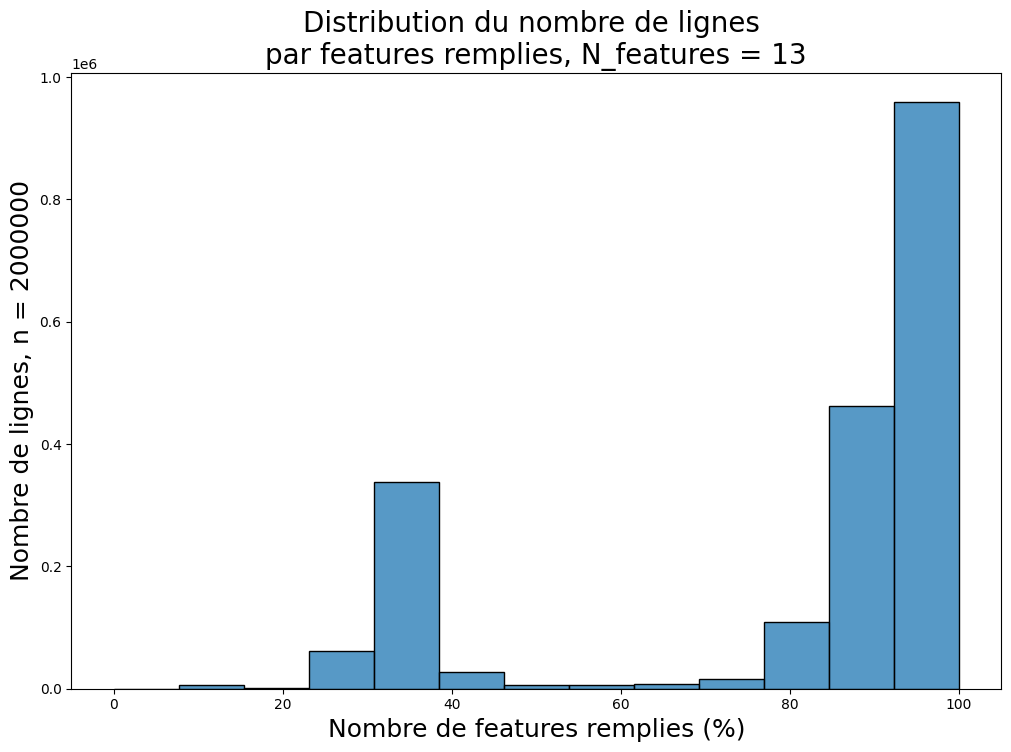

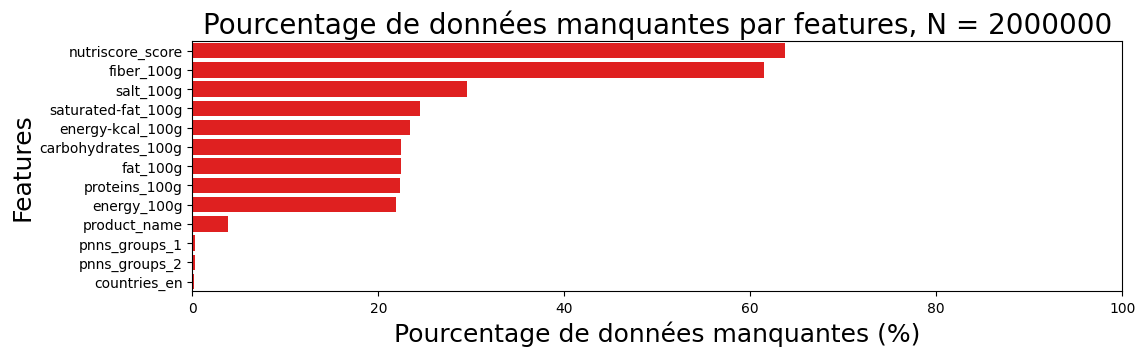

In [31]:
valeurs_manquantes_graph(data,'row')
valeurs_manquantes_graph(data,'column')

### Observations :

La majorité des features n'a pas ou peu de valeurs (99-100 %), comme le montre le barplot. 

On peut déjà supprimer les features avec 100 % de valeurs manquantes.

On va garder les autres pour l'instant, qui pourraient nous servir à trouver les valeurs aberrantes.

### <a name = "T2C5">e. Elimination des features à 100 % de valeurs manquantes</a>


In [32]:
## Donne accès aux opérateurs
import operator

## Fonction permettant d'éliminer les features selon le(s) critère(s) donné(s)
def eliminationFeature(df, critere_number, critere_ope, feature = 0):
    # Prend en arguments:
        ## df : dataframe à modifier
        ## critere_number : pourcentage sur lequel l'élimination sera réalisée (peut envoyer une liste)
        ## critere_ope : opérator en "" utilisé (peut envoyer une liste)

    # Dictionnaire permettant de convertir critere_ope str en operator
    rel_ops = {
        '>': operator.gt,
        '<': operator.lt,
        '>=': operator.ge,
        '<=': operator.le,
        '==': operator.eq,
        '!=': operator.ne
    }
    
    if feature == 0:
        feature = df.columns
    
    # On calcule le pourcentage de valeurs manquantes par features
    donnees_manquantes = [[col, df[col].isnull().sum() / df.shape[0] * 100] for col in feature]

    #On transforme notre liste contenant les données manquantes en dataframe
    donnees_manquantes = pd.DataFrame(donnees_manquantes, columns = ['Features', 'Pourcentage manquant'])
    
    ## on récupère la liste de feature à éliminer selon le critère
    liste_elimination = donnees_manquantes.loc[rel_ops[critere_ope](donnees_manquantes["Pourcentage manquant"], critere_number) , "Features"]
    
    print("On passe de %d" %df.shape[1], end = " ")
    [df.pop(col) for col in liste_elimination]
    print("à %d features" %df.shape[1])
    print("Avec cette liste de features éliminées :")
    
    with pd.option_context('display.max_rows', None):
        display(liste_elimination)
    
    return df

In [33]:
# On appel notre fonction afin d'éliminer les features avec 100 % de valeurs manquantes
data = eliminationFeature(data, 100, "==")

On passe de 13 à 13 features
Avec cette liste de features éliminées :


Series([], Name: Features, dtype: object)

### <a name = "T2C6">f. Data clean-up</a>

We will only keep for now completed products

In [34]:
print("We going from %d rows" %data.shape[0], end = " ")
data = data[data.isnull().sum(axis = 1) == 0]
print("to %d rows after clean-up" %data.shape[0])

We going from 2000000 rows to 417471 rows after clean-up


Le **nom du produit** est essentiel pour le développement de notre application et en absence de son nom, il serait plus difficile de retrouver le produit. C'est pareil pour le **code**.

On va donc éliminer ces produits.


In [35]:
"""print("Il y a %d lignes où le nom du produit n'est pas renseigné" %data["product_name"].isnull().sum())

ligne_elimination_index = data.loc[data["product_name"].isnull()].index 

print("On passe de %d" %data.shape[0], end = " ")
data = data.loc[~data.index.isin(ligne_elimination_index)]
print("à %d lignes" %data.shape[0])"""

'print("Il y a %d lignes où le nom du produit n\'est pas renseigné" %data["product_name"].isnull().sum())\n\nligne_elimination_index = data.loc[data["product_name"].isnull()].index \n\nprint("On passe de %d" %data.shape[0], end = " ")\ndata = data.loc[~data.index.isin(ligne_elimination_index)]\nprint("à %d lignes" %data.shape[0])'

In [36]:
"""print("Il y a %d lignes où le code du produit n'est pas renseigné" %data["code"].isnull().sum())

ligne_elimination_index = data.loc[data["code"].isnull()].index 

print("On passe de %d" %data.shape[0], end = " ")
data = data.loc[~data.index.isin(ligne_elimination_index)]
print("à %d lignes" %data.shape[0])"""

'print("Il y a %d lignes où le code du produit n\'est pas renseigné" %data["code"].isnull().sum())\n\nligne_elimination_index = data.loc[data["code"].isnull()].index \n\nprint("On passe de %d" %data.shape[0], end = " ")\ndata = data.loc[~data.index.isin(ligne_elimination_index)]\nprint("à %d lignes" %data.shape[0])'

Egalement, une **absence totale d'information nutritionnelle** sur les produits est préjudiciable. 

Ces produits seront éliminés si 100 % d'information est manquante. 

In [37]:
"""# On récupère les features ayant comme informations les valeurs nutritives (+nutriscore)
poids_cols = [col for col in data.columns if "100g" in col]

valeurs_manquantes_graph(data[poids_cols],"row")"""


'# On récupère les features ayant comme informations les valeurs nutritives (+nutriscore)\npoids_cols = [col for col in data.columns if "100g" in col]\n\nvaleurs_manquantes_graph(data[poids_cols],"row")'

In [38]:
## Donne accès aux opérateurs
import operator

## Fonction permettant d'éliminer les lignes selon le(s) critère(s) donné(s)
def eliminationRows(df, critere_number, critere_ope, feature = 0):
    # Prend en arguments:
        ## df : dataframe à modifier
        ## feature : df.columns si aucune sous_liste spécifiée
        ## critere_number : pourcentage sur lequel l'élimination sera réalisée (peut envoyer une liste)
        ## 0 = 0 données, 100 = 100% des données remplies
        ## critere_ope : opérator en "" utilisé (peut envoyer une liste)

    # Dictionnaire permettant de convertir critere_ope str en operator
    rel_ops = {
        '>': operator.gt,
        '<': operator.lt,
        '>=': operator.ge,
        '<=': operator.le,
        '==': operator.eq,
        '!=': operator.ne
    }
    
    if feature == 0:
        feature = df.columns
    
    # Comptage du nombre de valeurs entrées par ligne
    valeur_nonNaN = df[feature].count(axis = 1)
    
    # Calcul de la proportion de complétude
    completude_donnees = valeur_nonNaN / len(feature) * 100
    
    # On récupère une liste d'indexes des lignes à éliminer selon le critère
    liste_index_elimination = completude_donnees[rel_ops[critere_ope](completude_donnees, critere_number)].index
    
    print("On passe de %d" %df.shape[0], end = " ")
    # On élimine les lignes qui sont présentes dans la liste récupérée
    df = df.loc[~df.index.isin(liste_index_elimination)]
    print("à %d lignes" %df.shape[0], end = " ")
    print("(- %d)" %liste_index_elimination.shape[0])
    
    return df

In [39]:
"""# On appel notre fonction permettant d'éliminer les lignes ayant 0 features remplies

data = eliminationRows(data, 0, "==", poids_cols)"""


'# On appel notre fonction permettant d\'éliminer les lignes ayant 0 features remplies\n\ndata = eliminationRows(data, 0, "==", poids_cols)'

Il y avait donc 41020 lignes sans informations nutritionnelles (>10% de la base de données).

### <a name = "T2C7">g. Duplicated datas</a>

Do we have any duplicated datas ?

In [40]:
display(data.loc[data.duplicated(keep = False),:])

,product_name,countries_en,nutriscore_score,pnns_groups_1,pnns_groups_2,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g
1021,Madeleines ChocoLait,France,17.0,Sugary snacks,Biscuits and cakes,460.0,1926.0,24.00,6.00,54.00,1.4,6.40,0.4800
1275,The best chocolate chip cookies in the world,United States,4.0,Sugary snacks,Biscuits and cakes,132.0,552.0,6.00,3.50,17.00,0.0,2.00,0.1250
1276,The best chocolate chip cookies in the world,United States,4.0,Sugary snacks,Biscuits and cakes,132.0,552.0,6.00,3.50,17.00,0.0,2.00,0.1250
1492,"The Madelaine Chocolate Company, Solid Milk Ch...",United States,24.0,Sugary snacks,Sweets,556.0,2326.0,33.33,19.44,58.33,2.8,8.33,0.2075
1497,"The Madelaine Chocolate Company, Solid Milk Ch...",United States,24.0,Sugary snacks,Sweets,556.0,2326.0,33.33,19.44,58.33,2.8,8.33,0.2075
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987810,"Barre De Chocolat Lait, Praliné, Caramel Et Ca...",France,22.0,Sugary snacks,Chocolate products,550.0,2301.0,35.40,16.40,50.10,3.7,9.60,0.1400
1990756,Eggs,United Kingdom,1.0,Fish Meat Eggs,Eggs,140.0,586.0,9.83,2.64,0.27,0.0,12.70,0.7750
1991676,Pure whey protein,France,0.0,unknown,unknown,377.0,1577.0,4.00,2.20,11.00,2.6,73.00,0.3800
1992776,Matcha Green Tea Powder,France,8.0,Beverages,Unsweetened beverages,372.0,1556.0,4.00,0.58,55.10,27.2,28.90,0.0200


Yes, we have some duplicated data. We will have to clean that up.

In [41]:
# Pour voir les duplicats il faut se baser sur le nom du produit. 
# Certains produits peuvent être vendus avec différentes quantités, on ne veut en garder qu'une référence du produit
# Certains produits peuvent être vendus dans différents pays, on veut garder cette information pour l'instant

#Criteres : on analyse les duplicats sur une liste de ces critères
"""criteres = ["product_name", "countries_tags"] + poids_cols

with pd.option_context('display.max_columns', None):
    display(data.loc[data[criteres].duplicated(keep = False),:].sort_values("product_name", ascending = False))

data.drop_duplicates(subset = criteres, keep = "first", inplace = True)

"""


'criteres = ["product_name", "countries_tags"] + poids_cols\n\nwith pd.option_context(\'display.max_columns\', None):\n    display(data.loc[data[criteres].duplicated(keep = False),:].sort_values("product_name", ascending = False))\n\ndata.drop_duplicates(subset = criteres, keep = "first", inplace = True)\n\n'

In [42]:
print("We going from %d rows" %data.shape[0], end = " ")
data.drop_duplicates(keep = "first", inplace = True)
print("to %d rows after clean-up" %data.shape[0])

We going from 417471 rows to 397839 rows after clean-up


In [43]:
# Les produits ne doivent pas avoir le même code, sauf duplicat

"""with pd.option_context('display.max_columns', None):
    display(data.loc[data["code"].duplicated(keep = False),:].sort_values("code", ascending = False))"""

'with pd.option_context(\'display.max_columns\', None):\n    display(data.loc[data["code"].duplicated(keep = False),:].sort_values("code", ascending = False))'

## Observation : 

Des produits aux noms différents ont le même code.

Etant donné qu'ils y en a peu, on les élimine de la base de données.

In [44]:
"""print("On passe de %d" %data.shape[0], end = " ")
data.drop_duplicates(subset = "code", keep= False, inplace = True)
print("à %d lignes" %data.shape[0])"""

'print("On passe de %d" %data.shape[0], end = " ")\ndata.drop_duplicates(subset = "code", keep= False, inplace = True)\nprint("à %d lignes" %data.shape[0])'

### <a name = "T2C8">h. Countries correction</a>

Countries information will be important, we need to correct any wrongfull entries 

In [45]:
"""donnees_manquantes =[] 

for col in ["countries", "countries_tags", "countries_fr"]:
    donnees_manquantes.append([col,data[col].isnull().sum()])

display(donnees_manquantes)"""

'donnees_manquantes =[] \n\nfor col in ["countries", "countries_tags", "countries_fr"]:\n    donnees_manquantes.append([col,data[col].isnull().sum()])\n\ndisplay(donnees_manquantes)'

Il y a quand même quelques valeurs manquantes.

Ca ne concerne que peu de pays, on va les éliminer.

In [46]:
"""ligne_elimination_index = data[data.countries.isnull()].index

print("On passe de %d" %data.shape[0], end = " ")
data = data.loc[~data.index.isin(ligne_elimination_index)]
print("à %d lignes" %data.shape[0])"""

'ligne_elimination_index = data[data.countries.isnull()].index\n\nprint("On passe de %d" %data.shape[0], end = " ")\ndata = data.loc[~data.index.isin(ligne_elimination_index)]\nprint("à %d lignes" %data.shape[0])'

Pour plus de faciliter, et car l'information est redondante, nous allons nous focaliser que sur "countries_fr"

In [47]:
unique_pays = data.countries_en.unique()
unique_pays

['France', 'United States', 'Canada', 'Belgium,France', 'France,United States', ..., 'Belgium,France,Spain,Guadalupe', 'Germany,Suiza', 'Austria,European Union,Germany', 'Belgium,Ireland', 'New Zealand,Spain']
Length: 2216
Categories (3954, object): ['10000', '12', '3-4', '9ш', ..., 'فرانسه', 'لا-‏ادري', '日本', '�']

In [48]:
first_step =  [pays.split(",") if len(pays.split(",")) > 1 else pays for pays in unique_pays]

# Flatten the nested list
flat_list =  [[i for i in item] if isinstance(item, list) else item for item in first_step]
flat_list = [item for row in flat_list for item in (row if isinstance(row, list) else [row])]

# Flatten and get unique values
unique_values = sorted(list(set(flat_list)))

print(unique_values)

['Afghanistan', 'Albania', 'Aldi', 'Alemania', 'Algeria', 'Algerie', 'Allemagne', 'Almost-everywhere', 'American Samoa', 'Andorra', 'Andorra-francia-portugal-espana', 'Angola', 'Anguilla', 'Antigua and Barbuda', 'Arabie-saoudite', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Autriche', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgica', 'Belgie', 'Belgien', 'Belgio', 'Belgique', 'Belgique-france', 'Belgium', 'Belgium-aldi', 'Belgium-france-slovenia', 'Benin', 'Bermuda', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon', 'Cameroun', 'Canada', 'Canada-etats-unis', 'Canada-france', 'Cape Verde', 'Caribbean Netherlands', 'Cayman Islands', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Cote-d-ivoire-france-en-switzerland', 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic', "Côte d'Ivoire", 'Danimarca', 'Democratic Republic of the Congo', 'Denmark', 'Deutschland', 'Djibouti', 'Dom-tom', 'Dominica', 'Domini

In [61]:
#We have some errors :

errors_countries = [
"Allemagne", "Aldi", "Alemania", "Almost-everywhere", "Andorra-francia-portugal-espana",
"Autriche",
"Arabie-saoudite",
"Belgique", 'Belgica', 'Belgie', 'Belgien', 'Belgio', 'Belgique-france', 'Belgium-aldi', 'Belgium-france-slovenia',
"Canada-france",
"Côte d'Ivoire", "Cameroun",
"En-us",
"En",
"Estados-unidos",
"France-en-canada",
"France-united-states",
"France-united-states-en-united-states",
"Francia",
"Frankreich",
"Francia-espana",
"Deutschland",
"Mark",
"Nederland",
"North-carolina",
"Republic-of-macedonia",
"Royaume-uni",
"en-mexico",
"U-taqa", 
"Spanien",
"es:en-mexico",
"fr:louisiane",
"السعودية",
    'Canada-etats-unis', 'Canada-france',
    'Cote-d-ivoire-france-en-switzerland', "Côte d'Ivoire", 'Danimarca', 
    'Dom-tom', 'East Germany', 
    'En', 'En-en-us', 'En-united-states', 'En-us', 'Espanha', 'Espania', 
    'Estados-unidos', 'Etats-unis', 'Europe', 'European Union', 'Frace',
    'France-emirats-arabes-unis-en-morocco', 'France-en-canada', 'France-espagne-suisse', 'France-espana', 'France-suisse', 
    'France-switzerland-germany', 'France-united-states', 'France-united-states-en-united-states', 'Francia', 'Francia-espana', 'Francja', 
    'Frankreich', 'Frankreich-deutschland-niederlande', 'Frankreich-en-germany', 'Frankreich-spanien', 'Frankrijk', 'French Guiana', 
    'French Polynesia', 'Galmudug', 'Germania', 'Grece', 'Griechenland', 
    'Guadalupe', 'Gwadelupa', 'Haiti', 'Hgvhhhhh', 'Hiszpania', 
    'Hjgfvjjj', 'Hrvatska', 'Hungaria',  
    'Irland', 'Irlande', 'Irlandia', 'Isle of Man', 'Italien', 'Jvvjjhhjh', 
    'La-reunion', 'Luxemburgo', 'Malte', 'Mark', 'Maroc', 'Marokko', 'Martinica', 'Martinique', 
    'Melbourne-show', 'Mexique', 'Moldova', 'Monde', 
    'Nederland', 'Niemcy', 'North-carolina', 'Paesi-bassi', 'Paises-bajos', 'Pays-bas', 'Pays-bas-france', 
    'Polen', 'Polinesia-francesa', 'Pologne', 'Polonia',
    'Polska', 'Polynesie-francaise', 'Ranska', 'Reino-unido', 'Republic-of-macedonia', 'Republika Srpska', 
    'Romania', 'Royaume-uni', 'Réunion', 'Schweden', 'Schweiz', 
    'Slowakia', 'Slowenien', 'Soviet Union', 'Spagna', 
    'Spanien', 'Suisse', 'Suiza', 'Suomi', 'Svizzera', 'Szwajcaria', 
     'U-taqa', 'Ungarn', 
    'Union-europeenne-france', 'United-kingdon', 'United-states-en-united-states', 
     'Vereinigte-staaten-von-amerika', 'Vereinigtes-konigreich', 
    'Water-from-lithuania', 'World', 'am:usa-uk', 'ar:espagne', 
    'de:allemagne', 'de:de-sh-efb-013-ec', 'de:eu-landwirtschaft', 'de:europa', 'de:hessen', 'de:hungaria', 'de:poland-romania', 'de:slowakia', 
    'el:κύπρο', 'es:belgique', 'es:en-mexico', 'es:espagne', 'es:spagna', 'fa:espagne', 'fr:80-des-vol', 'fr:alemania', 'fr:angleterre', 
    'fr:belgica', 'fr:belgie', 'fr:belgien', 'fr:belgique-france-portugal', 'fr:bi1-auchan-fr-77480-mousseaux-les-bray', 'fr:deutschland', 
    'fr:dom-tom', 'fr:espagne-🇪🇸', 'fr:espanha', 'fr:espanya', 'fr:estados-unidos', 'fr:fabrique-en-france', 'fr:farine-de-ble-europeenne', 
    'fr:fr-bio-01', 'fr:fr29-269-020ce', 'fr:franca', 'fr:france-afrique-moyen-orient', 'fr:france-gironde', 'fr:france-only', 'fr:france🇨🇵', 
    'fr:francia', 'fr:francia-espana', 'fr:franciaorszag', 'fr:francja', 'fr:frankreich', 'fr:frankrijk', 'fr:franța', 'fr:grecia', 'fr:guadalupe', 
    'fr:hiszpania', 'fr:hungria', 'fr:international', 'fr:italie-🇮🇹🍝', 'fr:lille', 'fr:louisiana', 'fr:louisiane', 'fr:luxemburgo', 
    'fr:magyarorszag', 'fr:marruecos', 'fr:martinica', 'fr:nederland', 'fr:niederlande', 'fr:normandie', 'fr:paises-bajos', 'fr:paris-france', 
    'fr:polinesia-francesa', 'fr:polonia', 'fr:polska', 'fr:portugal🇵🇹', 'fr:quebec', 'fr:romenia', 'fr:saint-genis-laval', 'fr:schweiz', 
    'fr:scotland', 'fr:spagna', 'fr:spanje', 'fr:sui', 'fr:suiza', 'fr:tailandia', 'fr:فرنسا', 'it:marina-di-cerveteri', 'nb:norwegen', 'nl:belgie', 
    'nl:moldavie', 'nl:roemenie', 'sk:německo', 'zh:美國', 'zh:英國', 'Åland Islands', 'Česko', 'Švedska', 'Švicarska', 'България', 'Франция', 
    'السعودية', '日本'
]

How many does it represent ?

In [65]:
# We retrieve all the countries names
whole_countries =  [pays.split(",") if len(pays.split(",")) > 1 else pays for pays in data.countries_en]

# Flatten the nested list
flat_list =  [[i for i in item] if isinstance(item, list) else item for item in whole_countries]

countries = [item for row in flat_list for item in (row if isinstance(row, list) else [row])]

for err in errors_countries:
    if countries.count(err) >= 10:
        print(err, countries.count(err))

Allemagne 14
Belgique 32
Côte d'Ivoire 32
En 28
Francia 45
Frankreich 58
Deutschland 174
Royaume-uni 11
Côte d'Ivoire 32
Dominican Republic 27
En 28
European Union 35
Francia 45
Frankreich 58
French Guiana 71
French Polynesia 229
Greece 108
Isle of Man 11
Martinique 209
Moldova 10
Romania 532
Royaume-uni 11
Réunion 445
Schweiz 17
Suisse 22
Suiza 10
World 3725
de:slowakia 13
fr:angleterre 47
fr:belgica 12
fr:francia 104
fr:frankreich 26
nl:belgie 10


In [69]:
to_del = []
for err in errors_countries:
    if countries.count(err) < 10:
        print(err, countries.count(err))
        to_del.append(err)

Aldi 1
Alemania 3
Almost-everywhere 1
Andorra-francia-portugal-espana 1
Autriche 2
Arabie-saoudite 1
Belgica 8
Belgie 3
Belgien 6
Belgio 3
Belgique-france 1
Belgium-aldi 1
Belgium-france-slovenia 1
Canada-france 1
Cameroun 1
En-us 2
Estados-unidos 4
France-en-canada 1
France-united-states 3
France-united-states-en-united-states 1
Francia-espana 3
Mark 1
Nederland 7
North-carolina 1
Republic-of-macedonia 2
en-mexico 0
U-taqa 1
Spanien 7
es:en-mexico 1
fr:louisiane 1
السعودية 1
Canada-etats-unis 1
Canada-france 1
Cote-d-ivoire-france-en-switzerland 1
Danimarca 1
Djibouti 3
Dom-tom 4
Dominica 2
East Germany 2
En-en-us 1
En-united-states 1
En-us 2
Espanha 1
Espania 1
Estados-unidos 4
Etats-unis 5
Europe 1
Frace 1
France-emirats-arabes-unis-en-morocco 1
France-en-canada 1
France-espagne-suisse 1
France-espana 1
France-suisse 1
France-switzerland-germany 1
France-united-states 3
France-united-states-en-united-states 1
Francia-espana 3
Francja 4
Frankreich-deutschland-niederlande 1
Frankreich

In [165]:
# We will search tags "xx:"" and eliminate them
#data["countries_en"] = data["countries_en"].str.replace("..:","", regex= True)

In [71]:
to_correct = {
"Germany" : ["Allemagne", "Deutschland", "Alemania", "East Germany"],
"Andorra,France,Portugal,Spain" : ["Andorra-francia-portugal-espana"],
"Austria" : ["Autriche"],
"Saudi Arabia" : ["Arabie-saoudite", "السعودية"],
"Belgium" : ["Belgique", 'Belgica', 'Belgie', 'Belgien', 'Belgio', 'Belgium-aldi', 'Belgium-france-slovenia', 'fr:belgica', 'nl:belgie'],
"Belgium,France" : ['Belgique-france'],
'Belgium,France,Slovenia' : ['Belgium-france-slovenia'],
"Cameroon" : ['Cameroun'],
"England" : ["En"],
"France" : ["Francia", "Frankreich", "Dom-tom", "Francja", "Frankrijk", "fr:francia", "fr:frankreich"],
"Guernesey" : ["Guernsey"],
"United Kingdom" : ["Royaume-uni", "fr:angleterre"],
"" : to_del,
"Spain" : ["Spanien"],
"Ivory Coast" : ["Côte d'Ivoire"],
"United States" : ["Estados-unidos", "North-carolina", "fr:louisiane", "En-us", "Etats-unis"],
"France,Canada" : ["France-en-canada", "Canada-france"],
"France,United States" : ["France-united-states-en-united-states", "France-united-states"],
"France,Spain" : ["Francia-espana"],
"Netherlands" : ["Nederland"],
"Republic of North Macedonia" : ["Republic-of-macedonia"],
"Mexico" : ["es:en-mexico"],
"Somalia" : ["Galmudug"],
"Guyane": ["French Guiana"], "guadeloupe":["Guadalupe"],
"Slovakia": ["slowakia"],
"Switzerland":["Suiza","Suisse", "Schweiz"]
}

In [72]:
# Correction des erreurs 
for key in to_correct:
    for k in to_correct.get(key) :
        print(k)
        data["countries_en"] = data["countries_en"].apply(lambda x : key if x == k else x if len(x.split(",")) == 1 
                                else ",".join([key if p == k else p for p in x.split(",")]))

        

Allemagne
Deutschland
Alemania
East Germany
Andorra-francia-portugal-espana
Autriche
Arabie-saoudite
السعودية
Belgique
Belgica
Belgie
Belgien
Belgio
Belgium-aldi
Belgium-france-slovenia
fr:belgica
nl:belgie
Belgique-france
Belgium-france-slovenia
Cameroun
En
Francia
Frankreich
Dom-tom
Francja
Frankrijk
fr:francia
fr:frankreich
Guernsey
Royaume-uni
fr:angleterre
Aldi
Alemania
Almost-everywhere
Andorra-francia-portugal-espana
Autriche
Arabie-saoudite
Belgica
Belgie
Belgien
Belgio
Belgique-france
Belgium-aldi
Belgium-france-slovenia
Canada-france
Cameroun
En-us
Estados-unidos
France-en-canada
France-united-states
France-united-states-en-united-states
Francia-espana
Mark
Nederland
North-carolina
Republic-of-macedonia
en-mexico
U-taqa
Spanien
es:en-mexico
fr:louisiane
السعودية
Canada-etats-unis
Canada-france
Cote-d-ivoire-france-en-switzerland
Danimarca
Djibouti
Dom-tom
Dominica
East Germany
En-en-us
En-united-states
En-us
Espanha
Espania
Estados-unidos
Etats-unis
Europe
Frace
France-emirat

In [73]:
raw_index = data[data["countries_en"]  == ""].index
print("We going from %d rows" %data.shape[0], end = " ")
data = data.loc[~data.index.isin(raw_index)]
print("to %d rows after clean-up" %data.shape[0])

We going from 397839 rows to 397772 rows after clean-up


### <a name = "T2C9">i. Distribution of products by countries</a>


In [113]:
def distributionPays(df, threshold = 100):

    """
    Calculate the occurence of each country
    To not show unimportant countries, we set a threshold (default = 100)
    """

    # We get the list of countries 
    whole_countries =  [pays.split(",") if len(pays.split(",")) > 1 else pays for pays in df.countries_en]
    
    # Flatten the nested list
    flat_list =  [[i for i in item] if isinstance(item, list) else item for item in whole_countries]
    
    countries = [item for row in flat_list for item in (row if isinstance(row, list) else [row])]

    # We get the unique identifiers
    countries_unique = set(countries)

    # We count
    count_countries = [[i, countries.count(i)] for i in countries_unique]

    # We transform to a pandas DataFrame
    count_countries = pd.DataFrame(count_countries, columns = ["Countries", "Number of products"]) 

    # We calculate the pourcent of the total
    count_countries["Pourcent"] = count_countries["Number of products"] / count_countries["Number of products"].sum() * 100  

    # We take a slice 
    mask = count_countries[count_countries["Number of products"] > threshold].sort_values("Pourcent")
    
    # We can show a tab view
    display(mask)

    # To adjust the size of the graph
    size = mask.shape[0]
    
    #On affiche ce comptage par un barplot
    plt.figure(figsize=(12,size*0.7))
    
    sns.barplot(data = mask.sort_values("Pourcent"), x = "Number of products", y = "Countries", color = "red", orient = "h")    
    plt.title("Nombre de produits par pays", fontsize = 20)
    plt.xlabel("Nombre de produits", fontsize=18)
    plt.ylabel("Pays", fontsize=18)
    
    plt.show()

    # We return a list of countries
    return list(mask.Countries.values)

,Countries,Number of products,Pourcent
52,United Kingdom,13712,3.239555
86,Germany,19439,4.592599
74,France,113544,26.825557
7,United States,232553,54.942259


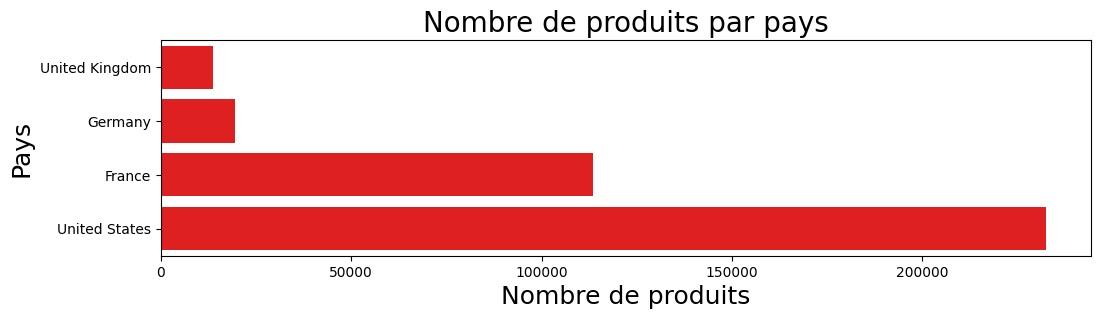

In [114]:
selected_countries = distributionPays(data, 10000)

In [115]:
selected_countries

['United Kingdom', 'Germany', 'France', 'United States']

***
# <a name = "T3"> Valeurs aberrantes et manquantes </a>

### <a name = "T3C1">a. Observation des valeurs nutritives </a>

We observed some numerical data to be false. 

We would like to correct this

In [77]:
g_feat = [col for col in data.columns if "100g" in col]
display(g_feat)

['energy-kcal_100g',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g']

In [79]:
with pd.option_context('display.max_columns', None):
    display(data[g_feat].describe())

,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g
count,3.977720e+05,3.977720e+05,397772.000000,397772.000000,397772.000000,397772.000000,3.977720e+05,397772.000000
mean,2.808133e+02,1.172863e+03,13.153635,4.603032,31.830456,2.909682,7.534219e+01,2.274299
std,1.727989e+03,7.219873e+03,16.212254,7.234093,27.614083,4.957946,4.228161e+04,460.727415
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,1.100000e+02,4.600000e+02,1.000000,0.000000,6.700000,0.000000,2.100000e+00,0.100000
50%,2.720000e+02,1.134000e+03,7.140000,1.700000,23.000000,1.500000,6.007067e+00,0.620000
75%,4.030000e+02,1.686000e+03,20.930000,6.620000,56.700000,3.600000,1.111111e+01,1.270000
max,1.082261e+06,4.528180e+06,822.000000,156.000000,1400.000000,963.000000,2.666667e+07,287500.000000


In [80]:
# To keep track of problematic data
over_limit = []

for col in g_feat :
    if col not in ["energy-kcal_100g", "energy_100g"]:
        over_limit.extend(data[data[col] > 100].index)
        display(data[data[col] > 100][["product_name"] + g_feat])
    elif col == "energy_100g" :
        over_limit.extend(data[data[col] > 3770].index)
        display(data[data[col] > 3770][["product_name"] + g_feat])
    elif col == "energy-kcal_100g" :
        over_limit.extend(data[data[col] > 945].index)
        display(data[data[col] > 945][["product_name"] + g_feat])

,product_name,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g
2632,Açai en polvo,2532.000000,10594.0,54.000000,14.000000,13.000000,20.0,9.000000,0.000000
7004,Orange dark chocolate truffles,2674.000000,11188.0,52.780000,36.110000,41.670000,2.8,5.560000,0.075000
8148,Cashews,2389.000000,9996.0,45.710000,8.570000,28.570000,5.7,17.140000,1.350000
35171,Morey's wild salmon sweet bourbon,1126.760563,4714.0,2.816901,0.352113,4.225352,0.0,18.309859,0.422535
72083,elderberry gummies,1000.000000,4184.0,0.000000,0.000000,100.000000,0.0,0.000000,18.750000
...,...,...,...,...,...,...,...,...,...
1982717,instant malted food drink,961.000000,1532.0,1.800000,1.800000,74.300000,1.9,13.100000,1.200000
1982851,pro oat cookie,1313.000000,5494.0,9.000000,3.680000,25.000000,1.8,32.000000,0.500000
1987017,Reload protein oat bar,1368.000000,958.0,13.000000,5.200000,31.000000,12.0,24.000000,0.780000
1994299,Salted Caramel,1113.000000,270.0,15.000000,12.000000,31.000000,3.0,2.200000,0.360000


,product_name,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g
2632,Açai en polvo,2532.000000,10594.0,54.00,14.000000,13.000,20.00,9.00,0.0000
7004,Orange dark chocolate truffles,2674.000000,11188.0,52.78,36.110000,41.670,2.80,5.56,0.0750
8148,Cashews,2389.000000,9996.0,45.71,8.570000,28.570,5.70,17.14,1.3500
11056,Garlic ghee,928.571429,3885.0,100.00,71.428571,0.000,0.00,0.00,0.0000
11065,Ghee packets,929.000000,3890.0,100.00,71.400000,0.000,0.00,0.00,0.0000
...,...,...,...,...,...,...,...,...,...
1958530,Extra mature cheddar slices,1190.000000,4930.0,99.70,62.000000,0.286,0.00,72.60,5.1700
1968856,Coconut oil,900.000000,3775.0,100.00,94.800000,0.000,0.00,0.00,0.0000
1978791,Strawberry Flakes,1780.000000,7440.0,1.11,1.670000,72.200,7.22,1.67,0.2780
1982851,pro oat cookie,1313.000000,5494.0,9.00,3.680000,25.000,1.80,32.00,0.5000


,product_name,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g
194862,Sainsbury's Taste the Difference Chilli Twists,507.0,2121.0,249.0,14.5,58.3,3.3,10.800,1.7300
200477,Dressing vegenaise soy free gluten free,4080.0,17100.0,459.0,25.5,0.0,0.0,0.000,9.5700
225050,Melton mowbray pork pie,355.0,1475.0,250.0,9.7,22.1,14.0,9.600,0.8000
225325,Hersheys Chipit butterscotch,3560.0,14900.0,178.0,156.0,444.0,0.0,44.400,3.8900
419968,Salted British butter,745.0,3062.0,822.0,52.1,0.6,0.5,0.600,1.5000
542837,Super bleu - Sans produits laitier,1440.0,6040.0,133.0,55.6,55.6,11.1,33.300,5.5600
700367,Chosen Foods Classic Mayo,4760.0,19900.0,524.0,71.4,0.0,0.0,0.000,5.9500
796207,Manteca Criolla de puerco,911.0,3810.0,101.0,32.4,0.0,0.0,0.714,0.0683
816379,Crokan,360.0,1506.0,135.0,7.5,51.0,6.0,6.000,0.3750
964262,Entrecôte mit Kräuter-Würzung (Bio),887.0,3711.0,212.0,15.0,5.0,0.5,19.000,0.7500


,product_name,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g
13362,Heavy Whipping Cream,333.0,1390.0,36.0,156.0,2.67,0.0,2.67,0.0833
225325,Hersheys Chipit butterscotch,3560.0,14900.0,178.0,156.0,444.00,0.0,44.40,3.8900
1890100,Арахіс смажений солоний,612.0,25391.0,519.0,156.0,104.00,0.0,26.00,17.0000


,product_name,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g
31050,Truvia,0.0,0.0,0.00,0.00,133.0,0.00,0.00,0.0000
39745,Crunchy Granola Bars,905.0,3790.0,33.30,4.76,138.0,9.52,14.30,2.1400
40146,Peanut Chewy Granola Bar,471.0,1970.0,23.50,7.35,471.0,8.53,8.82,2.9400
40531,Nature Valley Crunchy Oats 'n Dark Chocolate G...,452.0,1890.0,45.40,8.50,164.0,11.40,17.00,2.1200
46964,Kashi golean honey almond flax crunch,17.8,74.1,17.80,1.49,116.0,26.80,29.70,1.1900
60910,Everything bagel seasoning,625.0,2620.0,0.00,0.00,125.0,0.00,0.00,20.3000
64414,Sourrageous drops,333.0,1390.0,0.00,0.00,256.0,0.00,0.00,0.6770
99549,Minced Garlic in Olive Oil,100.0,420.0,0.00,0.00,400.0,0.00,0.00,0.0000
104241,Extra long grain brown rice,850.0,3560.0,5.67,0.00,181.0,5.67,17.00,0.0000
119492,Pringles Cheddar Cheese,536.0,2240.0,32.10,8.93,204.0,3.57,3.57,1.6100


,product_name,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g
188579,Green Lentils,112.0,465.0,0.5,0.10,8.3,173.0,9.9,0.0300
199938,Sainsbury's Puff Pastry,404.0,1685.0,23.7,10.70,40.5,193.0,6.5,0.4600
525756,Refreshingly Sweet Tea,1630.0,6830.0,0.0,0.00,600.0,150.0,16.7,0.2080
886896,"Dulano, Geflügelbratwurst Fleischerzeugnisse",232.0,971.0,18.0,5.40,1.0,963.0,16.0,2.5000
1421800,Flageolets verts,87.0,365.0,0.6,0.60,12.0,150.0,60.0,0.8100
1897213,สาหร่ายอบกรอบปรุงรส รสเผ็ด - 25 g,1480.0,6180.0,14.0,2.08,167.0,101.0,160.0,0.0172
1980395,Naked sausages,227.0,941.0,18.0,6.40,0.2,175.0,15.6,1.3100


,product_name,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g
221836,Sauce worcestshire,0.0,0.0,0.0,0.00,0.0,0.000,2000.0,600.0000
527774,Hot Buttered Rum Cheesecake,354.0,1480.0,22.1,12.40,31.0,0.885,106.0,0.8630
537630,Spiruline,45.0,188.0,0.0,0.00,1.0,0.000,26666667.0,0.1125
743287,โมเมนตั้ม รสสไปซี่บาร์บีคิว,1560.0,6510.0,76.7,10.00,157.0,56.700,110.0,4.7200
1774928,WHEY PROTEIN BLEND,708.0,2960.0,10.4,8.33,33.3,2.040,125.0,0.8850
1886297,Savor Liquid Seasoning Chilimansi,3510.0,14700.0,0.0,0.00,702.0,0.000,351.0,539.0000
1897213,สาหร่ายอบกรอบปรุงรส รสเผ็ด - 25 g,1480.0,6180.0,14.0,2.08,167.0,101.000,160.0,0.0172
1931287,Crisps,517.0,2156.0,30.5,2.80,51.0,5.200,556.7,1.3000
1939782,Sultanas,285.0,1193.0,0.3,0.10,64.7,5.500,391.1,0.1000
1971428,Dried Figs,255.0,1068.0,0.6,0.00,59.0,10.000,304.0,0.1000


,product_name,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g
7238,Lindor dark assortment,638.888889,2673.0,52.777778,38.888889,38.888889,5.555556,5.555556,104.166667
11532,Marshmallow,321.428571,1345.0,0.000000,0.000000,82.142857,0.000000,3.571429,133.928571
16024,Blue corn tortilla chips,494.000000,2070.0,21.200000,1.760000,67.000000,7.050000,7.050000,1010.000000
30819,Annie’s mac & extreme cheese,395.000000,1650.0,9.210000,5.260000,63.200000,5.260000,14.500000,2470.000000
30820,Annie's limited edition Mac & [extreme] cheese,395.000000,1650.0,9.210000,5.260000,64.500000,5.260000,14.500000,2470.000000
...,...,...,...,...,...,...,...,...,...
1777807,Belmont Maple Brown Sugar Mini Bundt Cake Deli...,357.000000,1490.0,12.900000,3.210000,53.600000,0.000000,5.000000,446.000000
1831172,Leinsamen geschrotet,514.000000,2151.0,40.600000,4.000000,1.600000,28.500000,21.200000,130.000000
1863920,protein bar,465.700000,1948.6,24.500000,9.200000,32.700000,5.900000,28.600000,166.500000
1886297,Savor Liquid Seasoning Chilimansi,3510.000000,14700.0,0.000000,0.000000,702.000000,0.000000,351.000000,539.000000


For now, we will eliminate the errors from the data set 

In [81]:
# We are flatting it
set(over_limit)

print("We going from %d rows" %data.shape[0], end = " ")
data = data[~data.index.isin(over_limit)]
print("to %d rows after clean-up" %data.shape[0])

We going from 397772 rows to 397247 rows after clean-up


In [82]:
def sommeplus (df, threshold = 100):
    """
    We eliminate when the sum of the macro is over the threshold
    """
    macro = ['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g']
    
    index_macro = df[df[macro].sum(axis = 1) > threshold].index

    df = df[~df.index.isin(index_macro)]

    print(index_macro.shape[0], "rows eliminated")

    return df

5882 rows eliminated


In [ ]:
data = sommeplus(data)

In [204]:
macro

[]

In [205]:
# We calculate the sum of the macro nutrients
data.loc[: ,"macronutrients_100g"] = data[['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g']].sum(axis = 1)

In [84]:
# Dimension of dataframe
print(data.shape)

(391365, 13)


In [100]:
data

,product_name,countries_en,nutriscore_score,pnns_groups_1,pnns_groups_2,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g
33,Tarte noix de coco,France,14.0,Composite foods,Pizza pies and quiches,381.000000,1594.0,22.000000,15.500000,27.300000,4.400000,4.600000,0.100000
43,Compote de poire,France,-2.0,Fruits and vegetables,Fruits,157.000000,657.0,0.000000,0.000000,36.000000,3.600000,0.600000,0.000000
81,BAguette bressan,France,-4.0,Cereals and potatoes,Bread,160.000000,669.0,2.200000,0.500000,25.200000,1.600000,9.500000,0.358000
309,Cranberries,United States,6.0,Fruits and vegetables,Fruits,300.000000,1255.0,0.000000,0.000000,83.330000,10.000000,0.000000,0.000000
371,Salade Cesar,Canada,14.0,Fruits and vegetables,Vegetables,290.000000,1210.0,12.000000,7.000000,23.000000,2.000000,22.000000,2.160000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999928,Prawn crackers sweet chili,United Kingdom,17.0,Salty snacks,Appetizers,510.526316,2136.0,25.789474,2.105263,68.947368,1.052632,1.052632,2.105263
1999929,Moringa Powder,United Kingdom,-3.0,unknown,unknown,268.000000,1121.0,7.000000,4.930000,4.490000,49.200000,26.230000,0.013400
1999976,Let's Get Ready To Rumble : Energy - Original,Belgium,6.0,unknown,unknown,19.000000,79.0,0.000000,0.000000,4.400000,0.000000,0.350000,0.150000
1999980,Pure C8 MCT oil,United Kingdom,20.0,Fat and sauces,Fats,899.000000,3761.0,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000


# Cleaning data

## Selected countries

In [124]:
# We select only data from selected countries
index_products = []
for country in selected_countries :
    index_products.extend(data.loc[data.countries_en.str.contains(country)].index)

# Eliminating duplicates
index_products = set(index_products)

In [126]:
# We discard data  

print("We going from %d rows" %data.shape[0], end = " ")
data = data.loc[data.index.isin(index_products)]
print("to %d rows after clean-up" %data.shape[0])

We going from 391365 rows to 370193 rows after clean-up


In [184]:
#data.loc[:, "countries_en"] = data["countries_en"].apply(lambda x: ','.join([country for country in x.split(",") if country in selected_countries]))
data.loc[:, "countries_en"] = data["countries_en"].apply(lambda x: ','.join(set(country for country in x.split(",") if country in selected_countries)))


We can check if some wrong datas were still there

In [185]:
# We select only data from selected countries
index_products = []
for country in selected_countries :
    index_products.extend(data.loc[data.countries_en.str.contains(country)].index)

# Eliminating duplicates
index_products = set(index_products)

In [186]:
# We discard data  

print("We going from %d rows" %data.shape[0], end = " ")
data = data.loc[data.index.isin(index_products)]
print("to %d rows after clean-up" %data.shape[0])

We going from 370189 rows to 370189 rows after clean-up


In [187]:
data["countries_en"].unique()

array(['France', 'United States', 'France,United States',
       'United Kingdom', 'Germany', 'Germany,United States',
       'United Kingdom,France', 'Germany,France',
       'United Kingdom,United States', 'Germany,France,United States',
       'United Kingdom,France,United States',
       'Germany,United Kingdom,France,United States',
       'Germany,United Kingdom', 'Germany,United Kingdom,France',
       'Germany,United Kingdom,United States'], dtype=object)

## Number formating

In [206]:
data.describe()

,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g,macronutrients_100g
count,370189.000000,370189.000000,370189.000000,370189.000000,370189.000000,370189.000000,370189.000000,370189.000000,370189.000000
mean,273.646578,1144.340802,12.852862,4.466070,31.493882,2.876460,8.216439,1.070114,53.633297
std,179.230020,749.245740,15.763629,6.936492,27.217370,4.616011,9.055206,3.014321,31.992501
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,108.000000,452.000000,0.900000,0.000000,6.700000,0.000000,2.020000,0.100000,23.600000
50%,267.000000,1117.000000,7.040000,1.670000,22.500000,1.500000,6.000000,0.620000,52.250000
75%,400.000000,1674.000000,20.000000,6.400000,56.000000,3.600000,11.110000,1.270000,86.830000
max,915.000000,3770.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.010000


We will round the data, to be in better presenting shape

In [209]:
data[g_feat] = round(data[g_feat], 2)
data[["energy-kcal_100g", "energy_100g"]] = round(data[["energy-kcal_100g", "energy_100g"]])
data[g_feat + ["macronutrients_100g"]]

,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g,macronutrients_100g
33,381.0,1594.0,22.00,15.50,27.30,4.40,4.60,0.10,54.00
43,157.0,657.0,0.00,0.00,36.00,3.60,0.60,0.00,36.60
81,160.0,669.0,2.20,0.50,25.20,1.60,9.50,0.36,37.26
309,300.0,1255.0,0.00,0.00,83.33,10.00,0.00,0.00,83.33
450,561.0,2318.0,53.20,9.60,11.70,1.30,8.20,2.70,75.80
...,...,...,...,...,...,...,...,...,...
1999927,492.0,2059.0,21.50,1.60,73.80,0.50,0.80,1.53,97.63
1999928,511.0,2136.0,25.79,2.11,68.95,1.05,1.05,2.11,97.90
1999929,268.0,1121.0,7.00,4.93,4.49,49.20,26.23,0.01,37.73
1999980,899.0,3761.0,100.00,100.00,0.00,0.00,0.00,0.00,100.00


In [94]:
def creation_file_csv(df, nom_du_fichier, path):
    
    ## On identifie si le format CSV a été entré, sinon on l'ajout
    if ".csv" not in nom_du_fichier:
        nom_du_fichier = nom_du_fichier + ".csv"

    file_path = os.path.join(path, nom_du_fichier)
    ## Le fichier est écrit au même endroit que le notebook
    ## Séparateur : tab
    df.to_csv(file_path, index = False, sep = "\t")

In [211]:
file_path = os.path.join(app_dir, 'files')
creation_file_csv(data, "cleaned_data", file_path)

- On observe:
    - Des valeurs négatives
        - Erreurs de saisie (- au lieu de +)
    - Des valeurs > 100g/100g
    - Des valeurs > 100 à 1000 fois supérieurs à la médiane
        - Pour les deux catégories, une erreur entre mg et g
    
- Résolution:
     - Valeurs négatives, passer en positives
     - Diviser par 1000 quand on voit que la valeur est trop éloignée de la médiane (valeur aberrante)

In [433]:
# Fonction permettant de tester si la modification impacte significativement la distribution de nos échantillons ou non
# Retourne True si la modification ne change pas significativement les données
# Retourne False si la modification ne change pas significativement les données
def resultcorrection_ttest(old_df, new_df, feature, paired = False):
    # Si les dataframes à comparer sont différents, on fait le test
    if old_df[feature].equals(new_df[feature]) == False:
       
       # Si on a plus de 1 valeur, on fait le test
        if(old_df[feature].count() > 1):
            
            if paired == True:
                # On exclu les valeurs NaN
                result_test = stats.ttest_rel(old_df[feature], new_df[feature], nan_policy = "omit")
                    
            else :
                
                if old_df[feature].notnull().sum() > new_df[feature].notnull().sum():
                    condition = old_df.index.isin(new_df.index)
                    result_test = stats.ttest_ind(old_df[feature][condition], new_df[feature], nan_policy = "omit")
                    
                if old_df[feature].notnull().sum() < new_df[feature].notnull().sum():
                    condition = new_df.index.isin(old_df.index)
                    result_test = stats.ttest_ind(old_df[feature], new_df[feature][condition], nan_policy = "omit")
                    
                if old_df[feature].notnull().sum() == new_df[feature].notnull().sum():
                    result_test = stats.ttest_ind(old_df[feature], new_df[feature], nan_policy = "omit")

        if result_test[1] <= 0.05:
            print(feature,": la modification change drastiquement les données, p_value:", result_test[1])
            graphique_boxplot(old_df[feature], new_df[feature], feature)
            standard_variation(old_df[feature], new_df[feature])
            return False

        else:
            return True
        

def graphique_boxplot(old_df, new_df, feature):
    pdFig = pd.DataFrame(columns = ["Avant", "Après"])
    pdFig["Avant"] = old_df
    pdFig["Après"] = new_df
    
    plt.figure(figsize=(5,5))
    plt.title("Distribution de la feature : "+str(feature), fontsize = 14)
    plt.ylabel("g/100g", fontsize=14)
    sns.boxplot(data = pdFig)
    plt.show()

def standard_variation(old_df, new_df):
    
    sv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100 

    sv_old = sv(old_df)
    sv_new = sv(new_df)

    print("Calcul du coefficient de variation :")
    print("Avant traitement = ", sv_old)
    print("Après traitement = ", sv_new)

#### <a name = "T3C2">2. Valeurs négatives</a>

Etant donné que les valeurs négatives sont potentiellement issues d'une mauvaise entrée, on va les corriger en les mettant en positif.

La modification ne devrait pas modifier la distribution de nos échantillons (test stats)

In [43]:
# Fonction pour corriger si la valeur entrée est négative
def corr_absolu(df, feature):
   
    for col in feature:
        # On regarde si une modification doit être réalisée
        
        if df.loc[df[col] < 0, col].count() > 0:
            
            #Test statistique de la modification
            mask = copy.deepcopy(df)
            mask.loc[df[col] < 0, col] = abs(mask.loc[df[col] < 0, col])
            
            #if resultcorrection_paired(df, mask, col) == True:
            if resultcorrection_ttest(df, mask, col, True) == True:
                df.loc[df[col] < 0, col] =  abs(df.loc[df[col] < 0, col])

    return df

In [434]:
"""data = corr_absolu(data, poids_cols)

with pd.option_context('display.max_columns', None):
    display(data[poids_cols].describe())"""

"data = corr_absolu(data, poids_cols)\n\nwith pd.option_context('display.max_columns', None):\n    display(data[poids_cols].describe())"

**Il n'y a plus de valeurs négatives**

##### <a name = "T3C3">3. Valeurs à la mauvaise unité</a>

On repère ces valeurs car elles sont soient :
- supérieure à 100/100g
- 100 à 1000 fois supérieures à la médiane


In [435]:
# Fonction permettant de corriger les valeurs mal entrée ou corrigée entre 100 et 110.
def ajustement(df, feature):
    df.loc[(df[feature] > 100) & (df[feature] <= 110), feature] = 100

    #On élimine quand c'est trop extrêmes
    index_elim = df[df[feature] > 110].index
    
    if(len(index_elim) > 0):
        df = df[~df.index.isin(index_elim)]
        print(len(index_elim),"lignes supprimées")
        
    return df

In [436]:
## Version 1

def mauvaiseUnite_corr(df) :
    
    remove_list = ['energy_100g','energy-from-fat_100g','nutrition-score-fr_100g','nutrition-score-uk_100g','carbon-footprint_100g']
    
    poids_cols = [col for col in df.columns if ("100g" in col) & (col not in remove_list)]
    
    with pd.option_context('display.max_columns', None):
        print("Avant correction :")
        display(df[poids_cols].describe())
    
    mask = copy.deepcopy(df)
    
    # Si on trouve une colonne où la valeur est >1000, on divise toutes les colonnes par 1000
    liste_valeurs_1000 = [y for col in poids_cols for y in df[df[col] > 1000].index]   
    # On garde l'indice quand une valeur excédentaire est retrouvée dans plus de 1 colonne 
    liste_valeurs_1000 = list(set([i for i in liste_valeurs_1000 if liste_valeurs_1000.count(i) >= 1])) 
    # On divise par 1000
    df.loc[df.index.isin(liste_valeurs_1000), poids_cols] = df.loc[df.index.isin(liste_valeurs_1000), poids_cols] / 1000
    
    # Si on retrouve une colonne où la valeur est > 100 et qu'une seconde l'est, on divise par 1000     
    # On récupère les indices où on retrouve une valeur > 100
    liste_valeurs_100 = [y for col in poids_cols for y in df[df[col] > 100].index]
    # On garde l'indice quand une valeur excédentaire est retrouvée dans plus de 2 colonnes 
    liste_valeurs_100 = list(set([i for i in liste_valeurs_100 if liste_valeurs_100.count(i) >= 2]))
    # On divise par 1000
    df.loc[df.index.isin(liste_valeurs_100), poids_cols] = df.loc[df.index.isin(liste_valeurs_100), poids_cols] / 1000
    
    # Test statistique
    for col in poids_cols:
        resultcorrection_ttest(mask, df, col, False)
    
    nb_ligne = df.shape[0]
    remove_list = ['energy_100g','energy-from-fat_100g','nutrition-score-fr_100g','nutrition-score-uk_100g','sodium_100g', "salt_100g",'carbon-footprint_100g']
    
    poids_cols = [col for col in df.columns if ("100g" in col) & (col not in remove_list)]
    for col in poids_cols :
        mask = copy.deepcopy(df)
        # Trans fat est à part. Il y a des aliments riches en trans fat
        if col != "trans-fat_100g":
            #Quand la moyenne/median est inférieur à 1. On cherche les outliers qui sont 50 fois supérieur.
            if df[col].median() > 0:
                med = df[col].median()
            else :
                med = df[col].mean()

            condition = (med < 1) & (df[col] > med * 50)
            
            #Tant qu'on est pas satisfait de la nouvelle valeur, on continue (le cas des valeurs qui sont 10^6 à leur vrai valeurs).
            while df.loc[condition, col].shape[0] > 0:
                condition = (med < 1) & (df[col] > med * 50)
                if df[col].median() > 0:
                    med = df[col].median()
                else :
                    med = df[col].mean()

                df.loc[condition, col] = (
                df.loc[condition, col].apply(lambda x: (x/100) 
                    if (abs(med - x / 100) < abs(med - x / 1000)) else (x/1000))) 
                
        
        # Test statistique
        resultcorrection_ttest(mask, df, col, False)
        
        # Si la valeur est comprise entre 100 et 110, elle est corrigée encore aberrante, elle est éliminée
        df = ajustement(df, col)    
    
    print("On passe de %d" %nb_ligne, end = " ")
    print("à %d lignes" %df.shape[0], end = " ")
    print("(- %d)" %(nb_ligne - df.shape[0]))
        
    with pd.option_context('display.max_columns', None):
        print("Après correction :")
        display(df[poids_cols].describe())
        
    return df

In [438]:
"""# On corrige les valeurs aberantes avec notre fonction
data = mauvaiseUnite_corr(data)"""

Avant correction :


,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,fiber_100g,proteins_100g,salt_100g
count,155588.000000,155588.000000,155588.000000,155588.000000,155588.000000,155588.000000,155588.000000
mean,282.263310,13.000365,4.504996,34.504634,2.558070,7.850160,3.652256
std,178.136457,15.354184,6.620711,28.277506,4.093587,9.504921,729.439021
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,112.902419,0.880000,0.000000,8.130000,0.000000,2.352941,0.155000
50%,286.000000,7.200000,1.770000,26.255000,1.300000,5.710000,0.765000
75%,406.000000,21.428571,6.850000,60.470000,3.571429,10.710000,1.470000
max,4080.000000,459.000000,156.000000,471.000000,193.000000,2000.000000,287500.000000


KeyboardInterrupt: 

Les résultats des tests statistiques montrent que pour certains nutriments, la distributions est significativement modifiées et comme on peut le voir sur les boxplot, après transformation, les outliers se retrouvent vers la médiane. Et en général, la moyenne est plus proche de la médiane après correction.

C'est confirmé par le calcul du coefficient de variation. On se rapproche de 100 pour la majorité des features (à l'exception de 2).

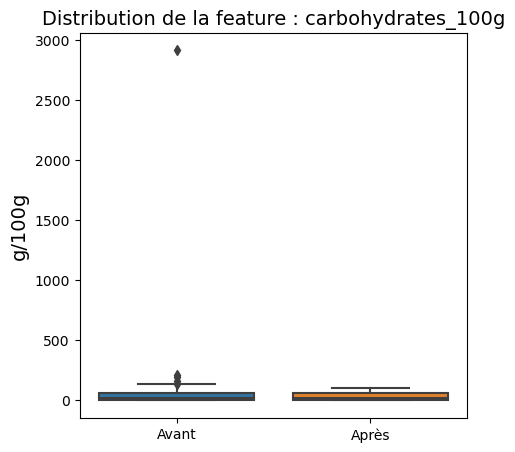

In [51]:
"""# Pour comparer, avant / après sur un macronutriment
graphique_boxplot(carboAvant, data["carbohydrates_100g"], "carbohydrates_100g")"""

On observe encore des valeurs aberrantes :

    - On peut retrouver 100 % de fat dans certains produits (huiles d'olives par exemple)
    - On peut retrouver 100 % de carbohydrates dans certains produits également
    
    - C'est anormal d'avoir autant de fibre (100%), surtout si nous comparons à la moyenne et ecart-type
    - Pareil pour les protéines (produits hyperprotéinés ne sont pas autant pourvus)


Regardons pour les protéines à 100/100g

In [52]:
"""with pd.option_context('display.max_columns', None):
    display(data.loc[data["proteins_100g"] == 100])"""

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,traces,traces_tags,traces_fr,serving_size,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,montanic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
2466,11110673671,http://world-fr.openfoodfacts.org/produit/0011...,usda-ndb-import,1489143364,2017-03-10T10:56:04Z,1489143364,2017-03-10T10:56:04Z,Unflavored Gelatin,NaN,NaN,NaN,NaN,"Kroger, The Kroger Co.","kroger,the-kroger-co",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,Etats-Unis,Gelatin.,NaN,NaN,NaN,NaN,7 g (0.25 ONZ),1.0,[ gelatin -> en:e428 -> exists -- ok ],en:e428,E428 - Gélatine,0.0,NaN,0.0,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN,NaN,NaN,NaN,1795.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36909,41250698784,http://world-fr.openfoodfacts.org/produit/0041...,usda-ndb-import,1489057821,2017-03-09T11:10:21Z,1489057821,2017-03-09T11:10:21Z,Unflavored Gelatin,NaN,NaN,NaN,NaN,Meijer,meijer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,Etats-Unis,Gelatin.,NaN,NaN,NaN,NaN,7 g (7 g),1.0,[ gelatin -> en:e428 -> exists -- ok ],en:e428,E428 - Gélatine,0.0,NaN,0.0,NaN,b,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN,NaN,NaN,NaN,1795.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,100.0,NaN,NaN,NaN,0.36322,0.143000,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,Na

On peut observer que de fausses informations ont été entrées (des films).

On élimine sur ce critère : "ingredients_text", si vide on enlève

In [53]:
"""index_elim = data.loc[(data["ingredients_text"].isnull()) & (data["proteins_100g"] == 100)].index
data = data.loc[~data.index.isin(index_elim)]"""

Observons les fibres à 100g/100g maintenant

In [54]:
"""with pd.option_context('display.max_columns', None):
    display(data.loc[data["fiber_100g"] == 100])"""

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,traces,traces_tags,traces_fr,serving_size,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,montanic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
9498,12511946067,http://world-fr.openfoodfacts.org/produit/0012...,usda-ndb-import,1489063583,2017-03-09T12:46:23Z,1489063583,2017-03-09T12:46:23Z,Sweeteners,NaN,NaN,NaN,NaN,Wholesome,wholesome,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,Etats-Unis,"Organic agave inulin, organic stevia extract (...",NaN,NaN,NaN,NaN,1 g (0.5 tsp),1.0,[ organic-agave-inulin -> en:organic-agave-in...,en:e551,E551 - Dioxyde de silicium,0.0,NaN,0.0,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,NaN,NaN,NaN,0.000,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76568,74410530525,http://world-fr.openfoodfacts.org/produit/0074...,usda-ndb-import,1489143631,2017-03-10T11:00:31Z,1489143631,2017-03-10T11:00:31Z,"Yamashin, Powdered Agar-Agar",NaN,NaN,NaN,NaN,Wismettac Asian Foods Inc.,wismettac-asian-foods-inc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,Etats-Unis,Seaweed.,NaN,NaN,NaN,NaN,4 g (1 PACKAGE),0.0,[ seaweed -> en:seaweed ],NaN,NaN,0.0,NaN,0.0,NaN,b,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN,NaN,NaN,NaN,1046.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,75.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,NaN,NaN,NaN,0.

100 g de fibre pourrait être correct pour ces aliments

#### <a name = "T3C4">4. Correction de la feature Fat_100g</a>

Le fat_100g est une feature majeure.

On recherche les valeurs pour lesquelles la somme des fats est supérieure à 'fat_100g' car ce sont des valeurs aberrantes

In [55]:
## Permet de corriger la valeur de fat_100g

def fat_corr(df):
    # Recherche des conditions où la somme des fats est plus grande que le total
    fats = ["saturated-fat_100g", "monounsaturated-fat_100g", "polyunsaturated-fat_100g", "trans-fat_100g"]

    # On récupère les index qui remplissent cette condition
    index_fat = df.loc[df[fats].sum(axis = 1) > df["fat_100g"]].index

    # On récupère les index où il n'y a pas de valeur entrées pour les fats
    index_nulle_fat = df.loc[df["fat_100g"].isnull()].index

    mask = copy.deepcopy(df)
    
    # On change la valeur par la somme
    df.loc[df.index.isin(index_fat), "fat_100g"] = df[fats].sum(axis = 1)
    df.loc[(df.index.isin(index_nulle_fat)) & (df[fats].sum(axis = 1) > 0), "fat_100g"] = df[fats].sum(axis = 1)

    print("Il y a ", index_fat.shape[0], "valeurs incorrectes et",index_nulle_fat.shape[0],"valeurs nulles.")
    print("Après correction, il y a", df.loc[(df["fat_100g"] > 100) & (df["fat_100g"] <= 110)].shape[0],"valeurs de fat entre 100 et 110 après correction")
    print("Après correction, il y a", df.loc[df["fat_100g"] > 110].shape[0], "valeurs de fat au dessus de 110 après correction")
    print("Après correction, il y a", df[df["fat_100g"].isnull()].shape[0],"valeurs de fat nulle après correction")
    
    # Pour corriger les erreurs de corrections
    df = ajustement(df, "fat_100g")
    
    
    # Test statistique
    # Sur les valeurs modifiées
    resultcorrection_ttest(mask[~mask.index.isin(index_nulle_fat)], df[~df.index.isin(index_nulle_fat)], "fat_100g", False)
    

    
    return df

In [56]:
"""display(data["fat_100g"].describe())

data = fat_corr(data)

display(data["fat_100g"].describe())"""

count    229805.000000
mean         12.622016
std          16.931071
min           0.000000
25%           0.000000
50%           5.310000
75%          20.000000
max         100.000000
Name: fat_100g, dtype: float64

Il y a  2405 valeurs incorrectes et 21647 valeurs nulles.
Après correction, il y a 117 valeurs de fat entre 100 et 110 après correction
Après correction, il y a 4 valeurs de fat au dessus de 110 après correction
Après correction, il y a 6286 valeurs de fat nulle après correction
4 lignes supprimées


count    245162.000000
mean         12.263180
std          16.679074
min           0.000000
25%           0.100000
50%           5.000000
75%          19.700000
max         100.000000
Name: fat_100g, dtype: float64

Il reste un grand nombre de valeurs nulles, néanmoins un grand nombre a pu être comblé en mesurant la valeur de fat avec les autres types de fat.

On observe que la distribution est modifié significativement. Mais la mesure du coefficient de variation montre que cette distribution est assez similaire à la distribution précédent la modification.

On tentera de compléter les valeurs manquantes par la suite.



In [472]:
def figure_feature(df, feature, style = "violinplot"):
    """
        To show the distribution of the feature
    """
    
    plt.figure(figsize=(12,6))

    if style == "boxplot":
        sns.boxplot(data = df[feature], color = "red", orient = "v")    
    elif style == "violinplot":
        sns.violinplot(data = df[feature], color = "red", orient = "v")

    plt.title("Distribution of the feature: "+str(feature), fontsize = 18)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.xlabel(str(feature), fontsize=18)
    plt.ylabel("g/100g", fontsize=14)

    plt.show()

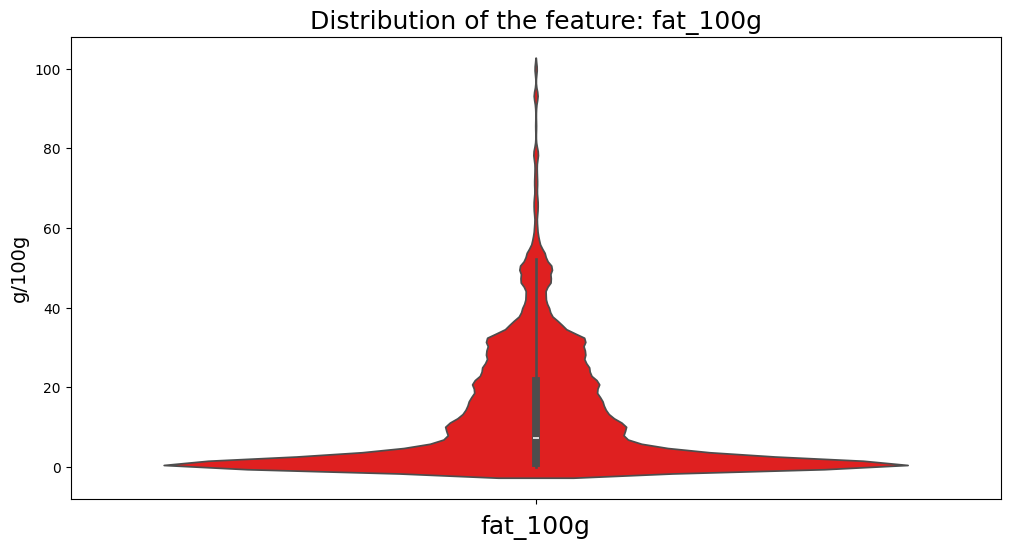

In [473]:
figure_feature(data, "fat_100g")

Une majorité des produits ont une faible teneur en gras.

#### <a name = "T3C5">5. Correction de la feature saturated-fat_100g</a>

Le saturated-fat_100g est une feature majeure.

On recherche le nombre de valeurs manquantes.

Puis on recalcul la valeur de fat-saturated_100g quand celle ci est manquante.

On pourra la mesurer à l'aide de la valeur fat remplie précédement et les autres paramètres de fat disponible.

In [59]:
def fat_saturated_corr(df):
    # Recherche des conditions où la somme des fats est plus grande que le total
    saturated = ["monounsaturated-fat_100g", "polyunsaturated-fat_100g", "trans-fat_100g"]
    
    # On récupère les index où la feature n'est pas rempli
    index_saturated = data.loc[data["saturated-fat_100g"].isnull()].index

    print("Il y a ",index_saturated.shape[0],"valeurs nulles.")

    mask = copy.deepcopy(df)
    
    # On met 0 quand fat = 0
    data.loc[(data.index.isin(index_saturated)) & (data["fat_100g"] == 0), "saturated-fat_100g"] = data["fat_100g"]
    index_saturated = data.loc[data["saturated-fat_100g"].isnull()].index

    print("Il reste ",index_saturated.shape[0],"valeurs nulles après correction avec fat = 0 = saturated_fat.")

    # On calcul saturated fat quand on a toutes les features d'entrées
    data.loc[(data.index.isin(index_saturated)) & (data[saturated].sum(axis = 1)> 0), "saturated-fat_100g"] =  data["fat_100g"] - data[saturated].sum(axis = 1)
    index_saturated = data.loc[data["saturated-fat_100g"].isnull()].index

    print("Il reste ",index_saturated.shape[0],"valeurs nulles après correction par saturated = fat - monounsat - polyunsa - trans-fat_100g")
    
    df = ajustement(df, "saturated-fat_100g")
   
    # Test statistique
    resultcorrection_ttest(mask, df, "saturated-fat_100g", False)

    return df

count    218835.000000
mean          5.111693
std           7.855197
min           0.000000
25%           0.000000
50%           1.800000
75%           7.140000
max         100.000000
Name: saturated-fat_100g, dtype: float64

Il y a  32613 valeurs nulles.
Il reste  10780 valeurs nulles après correction avec fat = 0 = saturated_fat.
Il reste  10697 valeurs nulles après correction par saturated = fat - monounsat - polyunsa - trans-fat_100g
saturated-fat_100g : la modification change drastiquement les données, p_value: 1.9425087173538218e-91


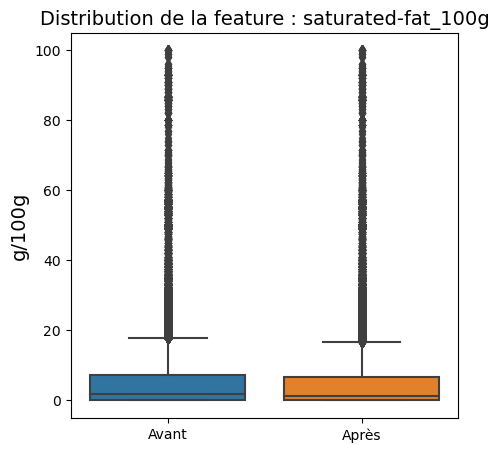

Calcul du coefficient de variation :
Avant traitement =  153.6711483955139
Après traitement =  164.20487156549015


count    240751.000000
mean          4.648034
std           7.632299
min           0.000000
25%           0.000000
50%           1.250000
75%           6.670000
max         100.000000
Name: saturated-fat_100g, dtype: float64

In [60]:
"""display(data["saturated-fat_100g"].describe())

data = fat_saturated_corr(data)

display(data["saturated-fat_100g"].describe())"""

Après remplissage des valeurs manquantes, il reste 10000 valeurs manquantes.

Les modifications effectuées modifient la distribution des valeurs.

Le coeffivient de variation le confirme, avec son augmentation après modification.

Les valeurs ajoutées n'ont donc pas la même distribution que celle qui étaient présentes. 

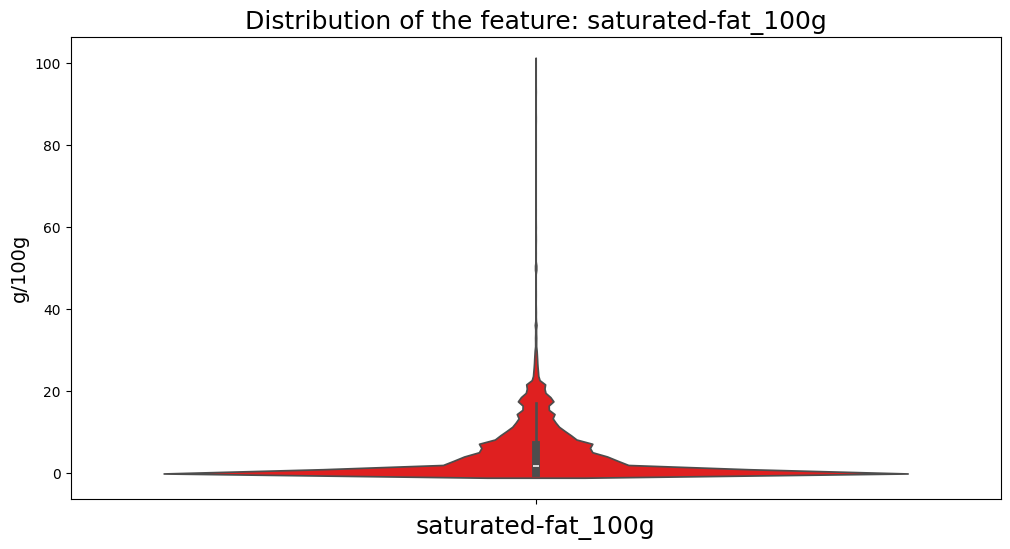

In [474]:
figure_feature(data, "saturated-fat_100g")

Similaire à ce qui est retrouvé avec la feature fat

#### <a name = "T3C6">6. Correction des la feature carbohydrates</a>

Le carbohydrate_100g est une feature majeure.

On recherche les valeurs pour lesquelles la somme des carbohydrates ("sugars_100g", "starch_100g", "fiber_100g") est supérieure à la valeur de 'carbohydrates_100g, ce qui correspond à une valeur aberrante.

In [62]:
def carbohydrate_corr(df):
    # Recherche des conditions où la somme des carbohydrates est plus grande que le total
    carbohydrates = ["sugars_100g", "starch_100g", "fiber_100g"]

    # On récupère les index qui remplissent cette condition
    index_sum_carbo = df.loc[df[carbohydrates].sum(axis = 1) > df["carbohydrates_100g"]].index

    # On récupère les index où il n'y a pas de valeur entrées pour les carbohydrates
    index_nulle_carbo = df.loc[df["carbohydrates_100g"].isnull()].index

    mask = copy.deepcopy(df)

    # On change la valeur par la somme
    df.loc[df.index.isin(index_sum_carbo), "carbohydrates_100g"] = df[carbohydrates].sum(axis = 1)
    df.loc[(df.index.isin(index_nulle_carbo)) & (df[carbohydrates].sum(axis = 1) > 0), "carbohydrates_100g"] = df[carbohydrates].sum(axis = 1)

    print("Il y a ", index_sum_carbo.shape[0], "valeurs incorrectes et",index_nulle_carbo.shape[0],"valeurs nulles.")
    print("Après correction, il y a", df.loc[(df["carbohydrates_100g"] > 100) & (df["carbohydrates_100g"] <= 110)].shape[0],"valeurs de carbohydrates entre 100 et 110 après correction")
    print("Après correction, il y a", df.loc[df["carbohydrates_100g"] > 110].shape[0], "valeurs de carbohydrates au dessus de 110 après correction")
    print("Après correction, il reste", df[df["carbohydrates_100g"].isnull()].shape[0],"valeurs de carbohydrates nulles")
    
    df = ajustement(df, "carbohydrates_100g")
    
    # Test statistique
    # Sur valeurs modifiées non nulle
    resultcorrection_ttest(mask, df, "carbohydrates_100g", False)
    
    return df

count    229486.000000
mean         32.373699
std          28.964316
min           0.000000
25%           6.350000
50%          21.430000
75%          58.700000
max         100.000000
Name: carbohydrates_100g, dtype: float64

Il y a  15080 valeurs incorrectes et 21962 valeurs nulles.
Après correction, il y a 15 valeurs de carbohydrates entre 100 et 110 après correction
Après correction, il y a 13 valeurs de carbohydrates au dessus de 110 après correction
Après correction, il reste 5371 valeurs de carbohydrates nulles
13 lignes supprimées
carbohydrates_100g : la modification change drastiquement les données, p_value: 4.724823820610983e-22


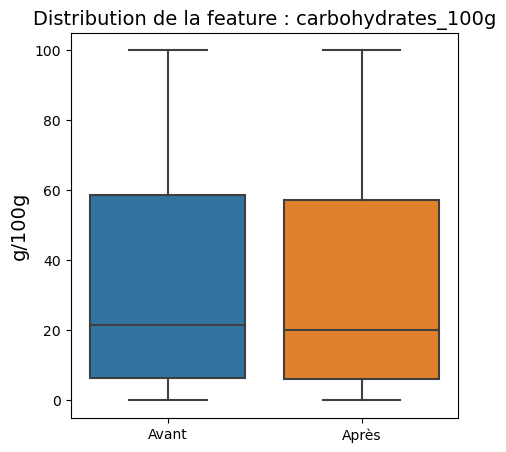

Calcul du coefficient de variation :
Avant traitement =  89.46866168072297
Après traitement =  91.02750381551633


count    246064.000000
mean         31.565538
std          28.733321
min           0.000000
25%           6.000000
50%          20.000000
75%          57.140000
max         100.000000
Name: carbohydrates_100g, dtype: float64

In [63]:
"""display(data["carbohydrates_100g"].describe())

data = carbohydrate_corr(data)

display(data["carbohydrates_100g"].describe())"""

On observe qu'il y avait un certain nombre de valeurs aberrantes (somme des carbo > valeur carbo).

Après correction, on observe des valeurs supérieures à 100. Cela pourrait provenir de valeurs mal corrigées précédemment. Ces lignes sont écartées.

On oberve que les modifications réalisées entraînent une modification significative de la distribution des valeurs. Ce qui est normal car pour 15080 valeurs, la quantité de carbohydrates est remesuré positivement.

Quand on analyse la distribution par boxplot avant et après, la médiane diminue très peu.

Donc la modification réalisée ne change pas dratiquement les valeurs.

Le coefficient de variation montre que les valeurs se sont rapprochées de la moyenne.

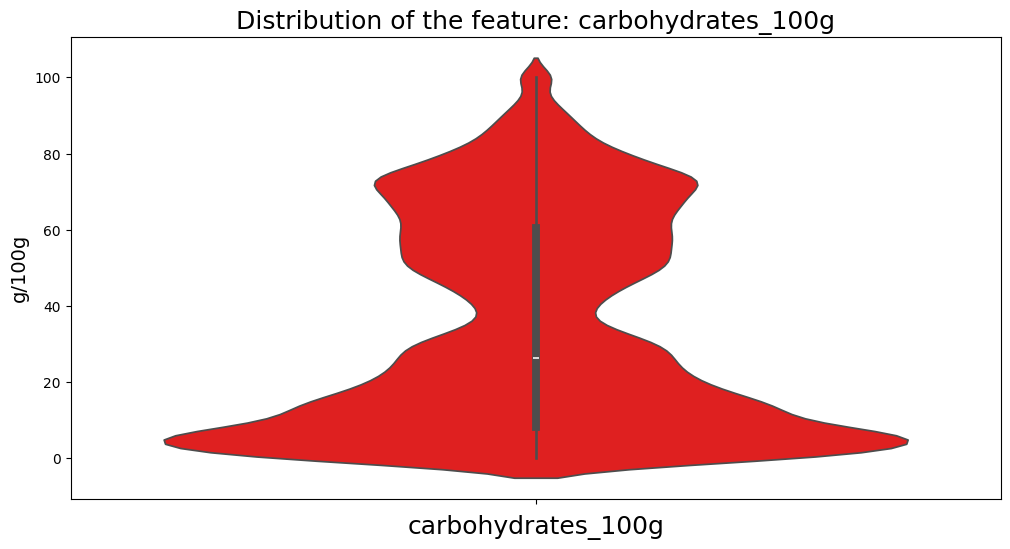

In [475]:
figure_feature(data, "carbohydrates_100g")

Deux types de produits : 
soient riches, soit pauvres en carbohydrates.

#### <a name = "T3C7">7. Correction des features Salt/Sodium</a>

Le salt_100g est une feature majeure.

In [476]:
"""# Calcul de la correlation entre Salt et Sodium
data["salt_100g"].corr(data["sodium_100g"])"""

'# Calcul de la correlation entre Salt et Sodium\ndata["salt_100g"].corr(data["sodium_100g"])'

Forte corrélation, ce qui est attendu.

In [66]:
"""data[["sodium_100g", "salt_100g"]].describe()"""

,sodium_100g,salt_100g
count,241551.000000,241591.000000
mean,0.627719,1.594149
std,2.512957,6.382494
min,0.000000,0.000000
25%,0.027000,0.068580
50%,0.232000,0.589280
75%,0.536000,1.361440
max,100.000000,254.000000


On retrouve des valeurs > 100

100g de sel de table (salt) = ~39,33 - 39,37 g de sodium.

Voyons voir si nous retrouvons cette valeur.

In [67]:
"""data["sodium_100g"].mean()/data["salt_100g"].mean() * 100"""

39.37643718850233

On est très proche de la valeur.
Dans tous les cas le sodium ne peut pa être supérieur à 39,37 g.

Corrigeons dans un premier temps le sel.

In [68]:
"""with pd.option_context('display.max_columns', None):
    display(data[data["salt_100g"] > 100])"""

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,traces,traces_tags,traces_fr,serving_size,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,montanic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
408,2124810206,http://world-fr.openfoodfacts.org/produit/0002...,usda-ndb-import,1489090470,2017-03-09T20:14:30Z,1489090470,2017-03-09T20:14:30Z,Mediterranean Sea Salt,NaN,NaN,NaN,NaN,Olde Thompson,olde-thompson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,Etats-Unis,Mediterranean sea salt.,NaN,NaN,NaN,NaN,1.2 g (0.25 tsp),0.0,[ mediterranean-sea-salt -> en:mediterranean-...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,105.83418,41.667000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3037,11110825261,http://world-fr.openfoodfacts.org/produit/0011...,usda-ndb-import,1489064104,2017-03-09T12:55:04Z,1489064104,2017-03-09T12:55:04Z,Coarse Kosher Salt,NaN,NaN,NaN,NaN,Kroger,kroger,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,Etats-Unis,"Salt, yellow prussiate of soda (anti-caking ag...",NaN,NaN,NaN,NaN,1.2 g (0.25 tsp),1.0,[ salt -> en:salt ] [ yellow-prussiate-of-s...,en:e535,E535 - Ferrocyanure de sodium,0.0,NaN,0.0,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Na

On retrouve des sels dans les valeurs > 100.

Ils se caractérisent par une absence d'énergie. 

On va pouvoir les corriger ainsi.

Le sodium sera recalculé via le sel.

In [69]:
def salt_sodium_corr(df):
    
    # Quand c'est du sel.
    salt_condition = (df["salt_100g"] > 100) & ((df["energy_100g"] == 0) | df["energy_100g"].isnull())

    mask = copy.deepcopy(df)
    
    # On met à 100g
    df.loc[salt_condition, "salt_100g"] = 100
    
    # Quand c'est supérieur à 100
    minimum = df.loc[df["salt_100g"] > 0, "salt_100g"].min()
    condition = (df["salt_100g"] > 100) & (df["salt_100g"]/1000 > minimum)
    df.loc[condition, "salt_100g"] = df.loc[condition, "salt_100g"]/1000
    
    # On recalcul le sodium avec le ratio
    ratio_moyenne = df["sodium_100g"].mean()/df["salt_100g"].mean()

    df["sodium_100g"] = df["salt_100g"] * ratio_moyenne
    
    # Test statistique
    resultcorrection_ttest(mask, df, "sodium_100g", False)
    
    # Test statistique
    resultcorrection_ttest(mask, df, "salt_100g", False)
    
    df = ajustement(df, "salt_100g")
    
    # On récupère les index où il n'y a pas de valeur entrées pour les salt
    index_nulle_salt = df.loc[df["salt_100g"].isnull()].index
    
    print("Il y a %d valeurs nulles." %index_nulle_salt.shape[0])
 
    
    return df

In [70]:
"""display(data[["salt_100g", "sodium_100g"]].describe())

data = salt_sodium_corr(data)

display(data[["salt_100g", "sodium_100g"]].describe())"""

,salt_100g,sodium_100g
count,241591.000000,241551.000000
mean,1.594149,0.627719
std,6.382494,2.512957
min,0.000000,0.000000
25%,0.068580,0.027000
50%,0.589280,0.232000
75%,1.361440,0.536000
max,254.000000,100.000000


Il y a 9844 valeurs nulles.


,salt_100g,sodium_100g
count,241591.000000,241591.000000
mean,1.581431,0.627719
std,6.192190,2.457871
min,0.000000,0.000000
25%,0.068580,0.027222
50%,0.589280,0.233903
75%,1.361440,0.540398
max,100.000000,39.693088


On a pu corriger les valeurs aberrantes.

Il reste des valeurs nulles, que nous tenterons de compléter par la suite.

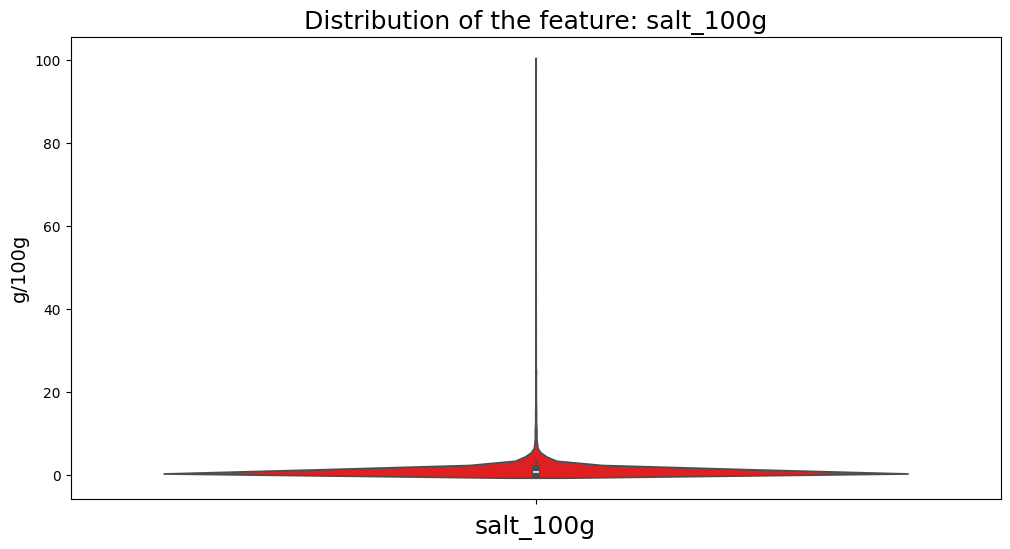

In [477]:
figure_feature(data, "salt_100g")

La majorité des produits sont pauvres en sel.

#### <a name = "T3C8">8. Valeurs extrêmes : somme des macro-éléments</a>

Si on fait la somme des macro-éléments, il n'est pas possible que cette valeur soit supérieure à 100g

On va donc rechercher les produits où on retrouve ces aberrations.

In [478]:
macro = [ 
'fat_100g',
 'carbohydrates_100g',
 'proteins_100g',
 'salt_100g',
]


In [479]:
# On recherche les features où il y a des valeurs aberrantes et on garde les indexes en mémoire
# On s'intéresse aux macro nutriments, car importants pour les calculs de nutriscore

somme_pos = []
# On analyse l'erreur entre la somme des macros entre 100 et 110
for i in range(101,111):
    somme_pos.append([i, data[data[macro].sum(axis = 1) > i].shape[0]])
       
# On transforme en DataFrame    
somme_pos = pd.DataFrame(somme_pos, columns = ["Somme", "Nombre"])
display(somme_pos)

,Somme,Nombre
0,101,1270
1,102,720
2,103,420
3,104,242
4,105,112
5,106,91
6,107,80
7,108,75
8,109,64
9,110,61


Si on accepte 0 % erreurs, 4000 lignes sont éliminées.

Si on accepte 10 % d'erreurs, 7 fois moins de lignes sont éliminées.

L'erreur étant minimime. On accepte 10 % d'erreur.

In [480]:
def sommeplus (df, threshold = 100):
    """
    We eliminate when the sum of the macro is over the threshold
    """
    macro = ['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g']
    
    index_macro = df[df[macro].sum(axis = 1) > threshold].index

    df = df[~df.index.isin(index_macro)]

    print(index_macro.shape[0], "rows eliminated")
    
    """# Test statistique
    for element in macro:
        resultcorrection_ttest(mask, df, element, False)
    """
    return df

In [481]:
data = sommeplus(data)

3110 rows eliminated


786 lignes ont été supprimées à la suite de cette opération.

Ces élimination n'entraînent pas de modification significative de la distribution.

In [484]:
data.loc[: ,"macronutrients_100g"] = data[macro].sum(axis = 1)

In [485]:
data["macronutrients_100g"].describe()

count    152316.000000
mean         55.611653
std          32.202335
min           0.000000
25%          24.565000
50%          55.475000
75%          89.290000
max         100.000000
Name: Macronutrients, dtype: float64

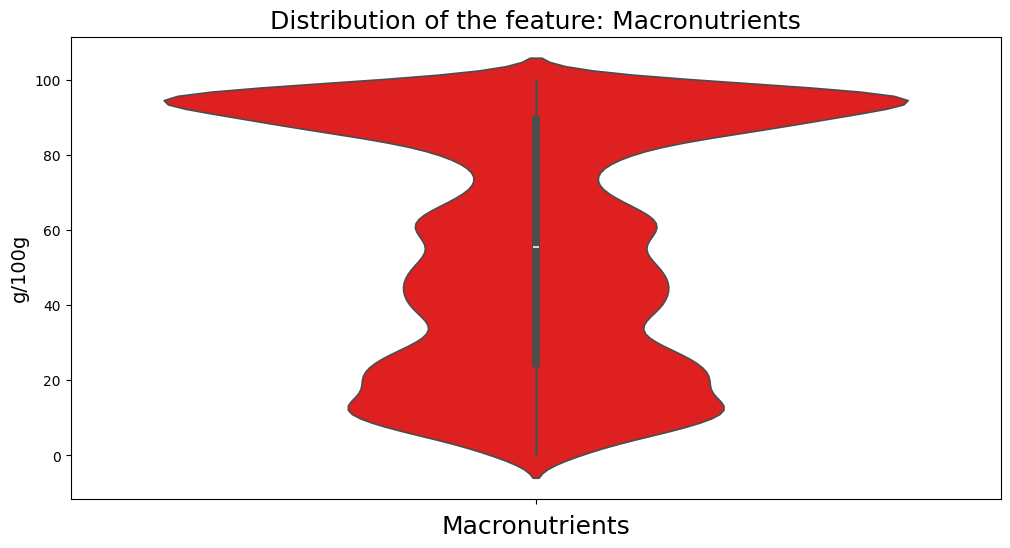

In [486]:
figure_feature(data, "macronutrients_100g")

Il y a 3 types de produits.
- Pauvres en macro nutriment < 30g/100g
- Intermédiaires en macro nutriments > 30 et < 80 g/100g
- Très riches en macro nutriments > 80 g/100g

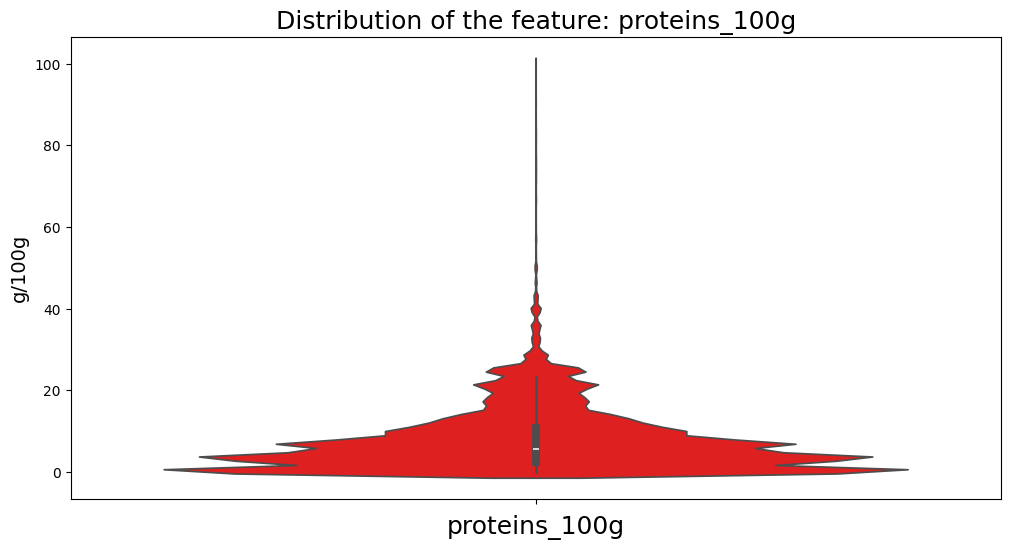

In [487]:
# Affichons les proteins
figure_feature(data, "proteins_100g")

Il semblerait que ce soit les carbohydrates qui contribuent le plus au haut de la distribution

#### <a name = "T3C9">9. Correction et remplissage d'energy-from-fat_100g </a>

In [79]:
"""print("Nombre de valeurs manquantes :",data["energy-from-fat_100g"].isnull().sum())
display(data["energy-from-fat_100g"].describe())"""

Nombre de valeurs manquantes : 249813


count     836.000000
mean      565.361112
std       693.596901
min         0.000000
25%        45.850000
50%       296.000000
75%       888.500000
max      3830.000000
Name: energy-from-fat_100g, dtype: float64

La feature est très peu remplie, mais elle est facilement remplissable.

En effet, 1g de fat correspond à 37,7 kJ.

Si on mesure le ratio actuel.

In [80]:
"""data.loc[data["energy-from-fat_100g"].notnull(), "energy-from-fat_100g"].sum()/data.loc[data["energy-from-fat_100g"].notnull(), "fat_100g"].sum()
"""

37.09314191640908

On est éloigné de la valeur théorique. Ce qui veut dire qu'il y a des erreurs d'entrées.

In [81]:
(data.loc[data["energy-from-fat_100g"].notnull(), "energy-from-fat_100g"]/data.loc[data["energy-from-fat_100g"].notnull(), "fat_100g"]).describe()


count    674.000000
mean            inf
std             NaN
min        0.000000
25%       35.914889
50%       37.493017
75%       41.899265
max             inf
dtype: float64

On va recalculer pour tout les produits.

In [82]:
## Fonction permettant de mesurer energy-from-fat_100g

def energy_fat(df):

    null_avant = df[df["energy-from-fat_100g"].isnull()].index
    
    mask = copy.deepcopy(df)
    
    #On fait la quantité de fat * 37,7 joules
    df["energy-from-fat_100g"] = df["fat_100g"] * 37.7
    
    null_apres = df[df["energy-from-fat_100g"].isnull()].index

    # Test statistique
    resultcorrection_ttest(mask[~mask.index.isin(null_avant)], df[~df.index.isin(null_avant)], "energy-from-fat_100g", False)

    print(null_avant.shape[0] - null_apres.shape[0],"données ont pu être rempli. Il en reste",null_apres.shape[0]," incomplètes")
    
    return df

In [83]:
data = energy_fat(data)

display(data["energy-from-fat_100g"].describe())

243531 données ont pu être rempli. Il en reste 6282  incomplètes


count    244367.000000
mean        460.057299
std         625.921737
min           0.000000
25%           3.770000
50%         188.500000
75%         736.846500
max        3770.000000
Name: energy-from-fat_100g, dtype: float64

In [84]:
data["fat_100g"].corr(data["energy-from-fat_100g"])

0.9999999999999983

Ce résultat est normal étant donné que nous avons mesuré l'énergy via la quantité de fat

C:\Users\33664\anaconda3\lib\site-packages\seaborn\_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


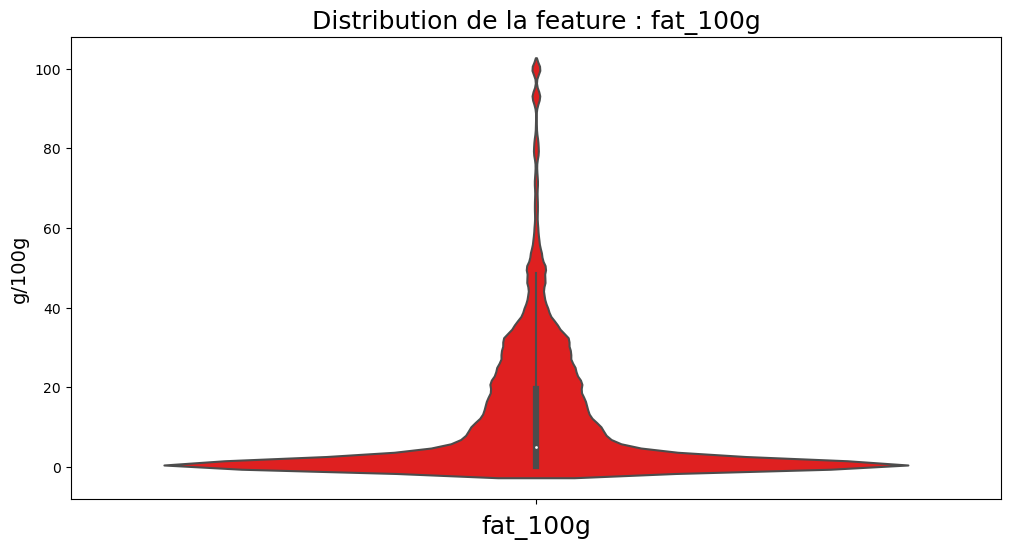

C:\Users\33664\anaconda3\lib\site-packages\seaborn\_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


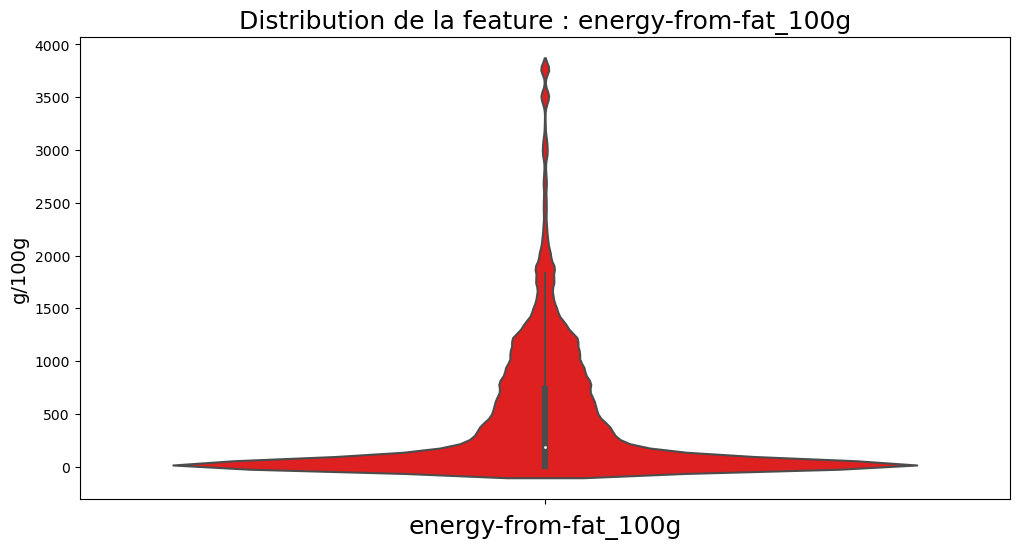

In [85]:
# on peut le confirmer visuellement.

figure_feature(data, "fat_100g")
figure_feature(data, "energy-from-fat_100g")

#### <a name = "T3C10">10. Correction et remplissage d'energy_100g </a>

In [86]:
print("Nombre de valeurs manquantes :",data["energy_100g"].isnull().sum())
display(data["energy_100g"].describe())

Nombre de valeurs manquantes : 4400


count    2.462490e+05
mean     1.142746e+03
std      6.630745e+03
min      0.000000e+00
25%      3.890000e+02
50%      1.100000e+03
75%      1.674000e+03
max      3.251373e+06
Name: energy_100g, dtype: float64

Il y a très peu de valeurs manquantes. Cependant, on peut observer des valeurs à 0.

C:\Users\33664\anaconda3\lib\site-packages\seaborn\_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


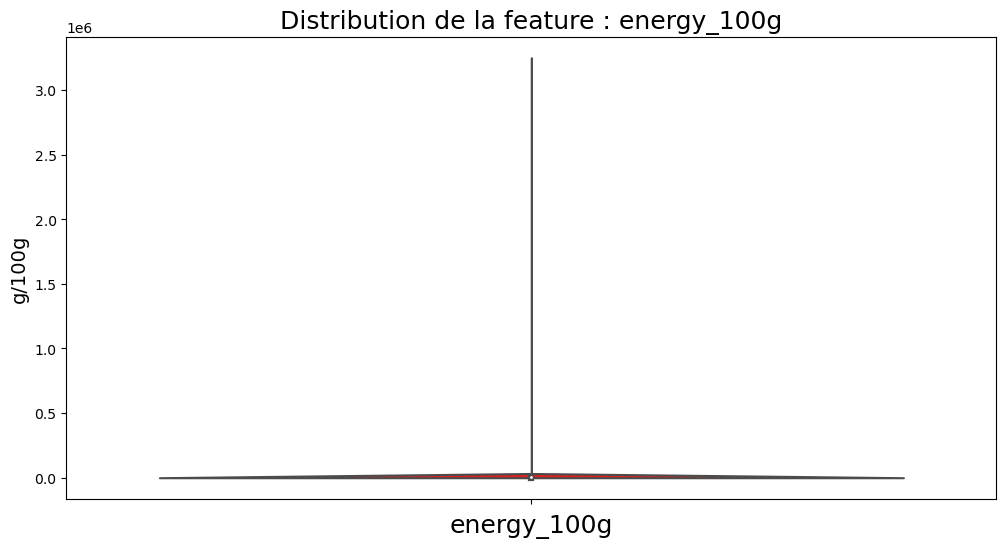

In [87]:
figure_feature(data, "energy_100g")

On peut re-calculer les valeurs manquantes ou aberrantes pour la feature "energy_100g".

**Pour 1 g de protéine ou de carbohydrate on obtient 16.7 kJ d'énergie et pour 1 g de fat, on obtient 37.7 kJ d'énergie**

In [88]:
## Fonction pour calculer l'énergie
def energy_calcul(df):

    energy = ['fat_100g', 'carbohydrates_100g', 'proteins_100g']

    cond1 = (df["energy_100g"].isnull()) # Si la valeur est nulle
    cond2 = (df["energy_100g"] < df["energy-from-fat_100g"]) # si la valeur est aberrante
    cond3 = (df["energy_100g"] > 3770) # Quand valeur supérieure au maximum théoorique
    cond4 = (df["energy_100g"] == 0) # Quand valeur = 0, on recalcul
    cond_final = (df[energy].sum(axis = 1) > 0) # Si la valeur est mesurable

    mask = copy.deepcopy(df)
    
    print("Nombre de valeurs aberrantes ", df[(cond1|cond2|cond3|cond4)].shape[0])
    print("null : ", df[cond1].shape[0],
         "<Nfat : ", df[cond2].shape[0],
         ">3770 : ", df[cond3].shape[0],
         "==0 : ", df[cond4].shape[0],
         "\n")
    print("Nombre de valeurs qui seront corrigées ", df[(cond1|cond2|cond3|cond4) & cond_final].shape[0])
    print("null : ", df[cond1 & cond_final].shape[0],
         "<Nfat : ", df[cond2 & cond_final].shape[0],
         ">3770 : ", df[cond3 & cond_final].shape[0],
         "==0 : ", df[cond4 & cond_final].shape[0],
         "\n")
    print("Nombre de valeurs qui resteront non-corrigées ", df[(cond1|cond2|cond3|cond4) & ~cond_final].shape[0])
    print("null : ", df[cond1 & ~cond_final].shape[0],
         "<Nfat : ", df[cond2 & ~cond_final].shape[0],
         ">3770 : ", df[cond3 & ~cond_final].shape[0],
         "==0 : ", df[cond4 & ~cond_final].shape[0],
         "\n")
    
    df.loc[(cond1|cond2|cond3|cond4) & cond_final, "energy_100g"] =( 
[(x[0]*37.7 if x[0] > 0 else 0) 
 + (x[1]*16.7 if x[1] > 0 else 0) 
 + (x[2]*16.7 if x[2] > 0 else 0) 
 for x in np.array(df.loc[(cond1|cond2|cond3|cond4) & cond_final, ['fat_100g',  'carbohydrates_100g', 'proteins_100g']])])
    
    # Test statistique
    resultcorrection_ttest(mask, df, "energy_100g", False)
    
    print("Nombre de valeurs nulles restantes ", df[cond1].shape[0])
    
    return df

In [89]:
data = energy_calcul(data)

Nombre de valeurs aberrantes  15877
null :  4400 <Nfat :  3828 >3770 :  306 ==0 :  7393 

Nombre de valeurs qui seront corrigées  6390
null :  1105 <Nfat :  3828 >3770 :  294 ==0 :  1213 

Nombre de valeurs qui resteront non-corrigées  9487
null :  3295 <Nfat :  0 >3770 :  12 ==0 :  6180 

Nombre de valeurs nulles restantes  4400


C:\Users\33664\anaconda3\lib\site-packages\seaborn\_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


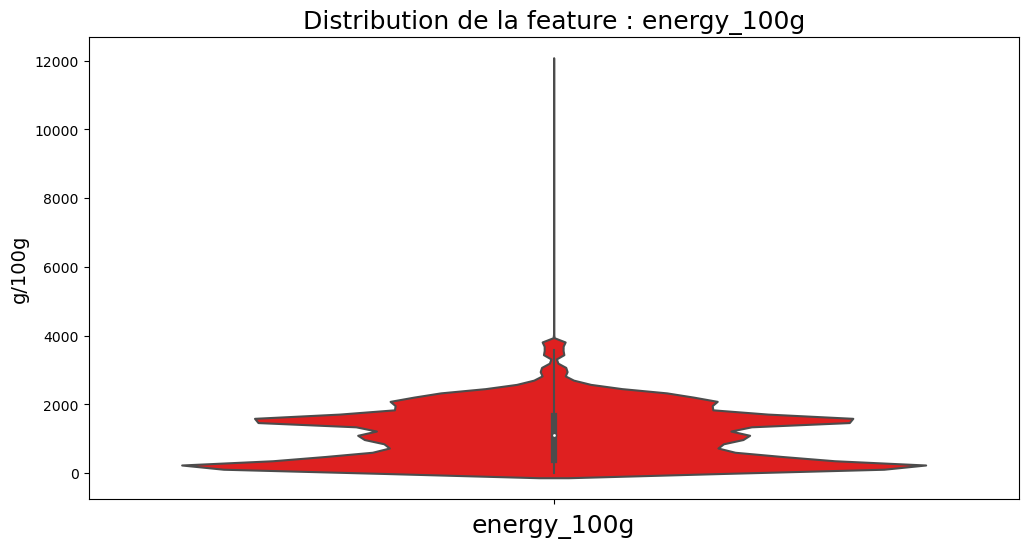

count    247354.000000
mean       1130.457918
std         786.827284
min           0.000000
25%         393.000000
50%        1109.000000
75%        1674.000000
max       11954.000000
Name: energy_100g, dtype: float64

In [90]:
figure_feature(data, "energy_100g")
display(data["energy_100g"].describe())

In [91]:
with pd.option_context('display.max_columns', None):
    display(data[data["energy_100g"]>4000][['energy_100g','fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g']])
    display(data[data["energy_100g"]>4000])

,energy_100g,fat_100g,carbohydrates_100g,proteins_100g,salt_100g
4874,5690.0,0.0,0.0,0.0,3.30200
25157,6975.0,0.0,0.0,0.0,0.00000
71049,11954.0,0.0,0.0,0.0,39.91356
81474,4184.0,0.0,0.0,0.0,0.00000
83268,5577.0,0.0,0.0,0.0,0.00000
83269,5577.0,0.0,0.0,0.0,0.00000
100931,6975.0,0.0,0.0,0.0,0.00000
106652,4184.0,0.0,0.0,0.0,30.48000
107990,4184.0,0.0,0.0,0.0,0.00000
116211,6276.0,0.0,0.0,0.0,0.00000


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,traces,traces_tags,traces_fr,serving_size,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,montanic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
4874,11150090834,http://world-fr.openfoodfacts.org/produit/0011...,usda-ndb-import,1489055247,2017-03-09T10:27:27Z,1489055247,2017-03-09T10:27:27Z,Traditional Dusseldorf Mustard,NaN,NaN,NaN,NaN,Roundy's,roundy-s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,Etats-Unis,"Vinegar, water, mustard seed, salt, red pepper.",NaN,NaN,NaN,NaN,5 g (1 tsp),0.0,[ vinegar -> en:vinegar ] [ water -> en:wat...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN,NaN,NaN,NaN,5690.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,3.30200,1.310666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25157,32251079443,http://world-fr.openfoodfacts.org/produit/0032...,usda-ndb-import,1489134186,2017-03-10T08:23:06Z,1489134186,2017-03-10T08:23:06Z,100% Natural Non-Stick Canola Cooking Spray Oil,NaN,NaN,NaN,NaN,Family Gourmet,family-gourmet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,Etats-Unis,"Canola oil, lecithin from soybeans, rosemary e...",NaN,NaN,NaN,NaN,0.3 g (0.25 SEC. SPRAY),0.0,[ canola-oil -> en:canola-oil ] [ oil -> en...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN,NaN,NaN,NaN,6975.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN

Ce sont soient des huiles, soit du sel.

Il n'y a pas d'informations nutritionnelles

Etant donné que ça concerne peu de produits, on les enlève.

In [92]:
data = data[data["energy_100g"]<4000]

C:\Users\33664\anaconda3\lib\site-packages\seaborn\_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


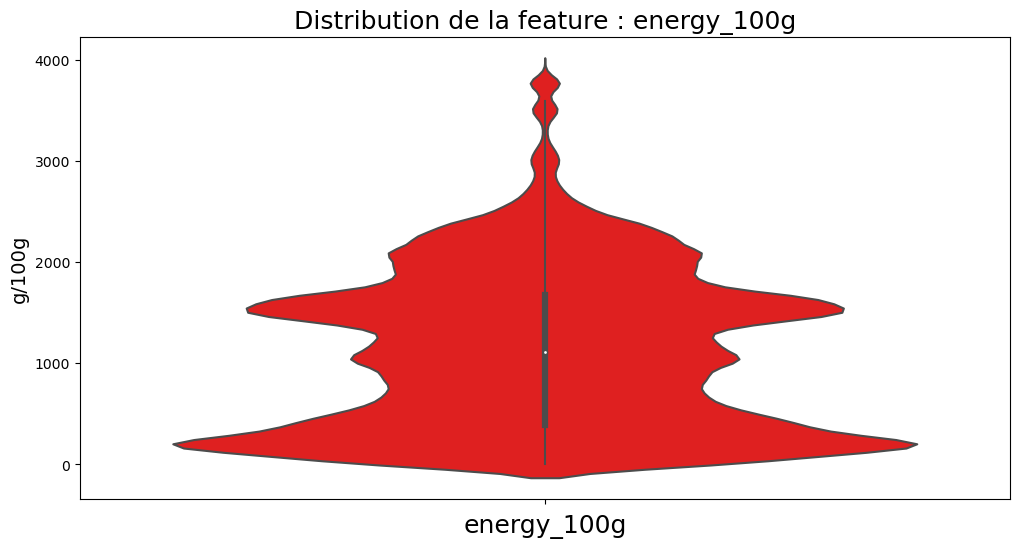

count    247342.000000
mean       1130.224349
std         785.999757
min           0.000000
25%         393.000000
50%        1109.000000
75%        1674.000000
max        3889.238000
Name: energy_100g, dtype: float64

In [93]:
figure_feature(data, "energy_100g")
display(data["energy_100g"].describe())

Très peu de produits riches en énergie.

#### <a name = "T3C11">11. Différence entre energy_100g mesurée et entrée </a>

En connaissant la quantité de Fat, Proteins et Sugars, on est sensé pouvoir trouver la valeur d'energy_100g.

En la remesurant, on fait donc l'hypothèse que la différence entre théorique et entrée soit faible.

Pour comparer, nous faisons sur les valeurs entrées > 0 et où on retrouve une valeur pour les 3 macros.

In [94]:
macro_nrj = ['fat_100g', 'carbohydrates_100g', 'proteins_100g']
cond1 = (data[macro_nrj].count(axis = 1) == 3) # 3 valeurs non nulles
cond2 = (data["energy_100g"].notnull()) # valeur energy non nulle

data[cond1 & cond2].shape[0]

241645

In [95]:
# On prend un slice du dataframe
dt = copy.deepcopy(data[cond1 & cond2])

dt["energy_100g"] =( 
[(x[0]*37.7 if x[0] > 0 else 0) 
 + (x[1]*16.7 if x[1] > 0 else 0) 
 + (x[2]*16.7 if x[2] > 0 else 0) 
 for x in np.array(dt[macro_nrj])])
    

count    247342.000000
mean       1130.224349
std         785.999757
min           0.000000
25%         393.000000
50%        1109.000000
75%        1674.000000
max        3889.238000
Name: energy_100g, dtype: float64

count    241645.000000
mean       1102.381055
std         790.199414
min           0.000000
25%         360.490000
50%        1062.099000
75%        1666.989000
max        3889.238000
Name: energy_100g, dtype: float64

C:\Users\33664\anaconda3\lib\site-packages\seaborn\_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


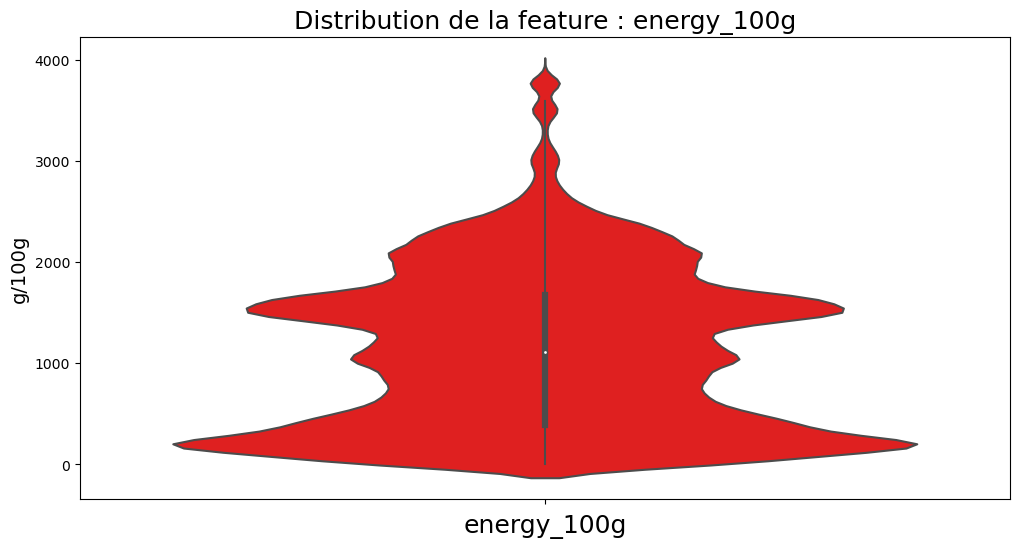

C:\Users\33664\anaconda3\lib\site-packages\seaborn\_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


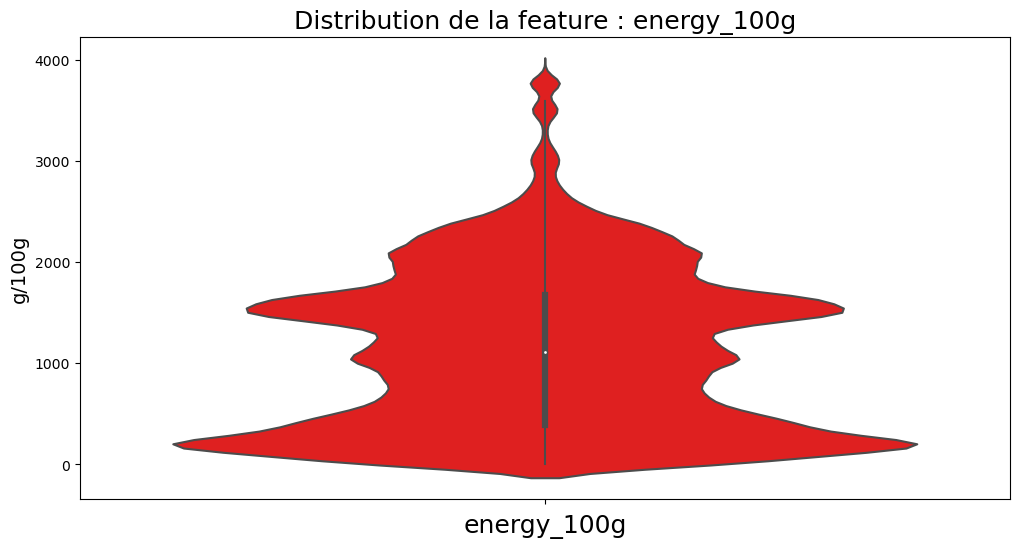

In [96]:
display(data["energy_100g"].describe())
display(dt["energy_100g"].describe())
figure_feature(data, "energy_100g")
figure_feature(data, "energy_100g")

In [97]:
#On mesure la différence entre la valeur de la base de données et la valeur calculée
dif = pd.DataFrame({"variation" : data[cond1 & cond2]["energy_100g"] - dt["energy_100g"]})

display(dif.describe())

,variation
count,241645.000000
mean,32.667095
std,228.458093
min,-1655.810000
25%,-17.536000
50%,1.803000
75%,27.240000
max,3556.000000


On affiche la dispersion de la différence.

C:\Users\33664\anaconda3\lib\site-packages\seaborn\_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


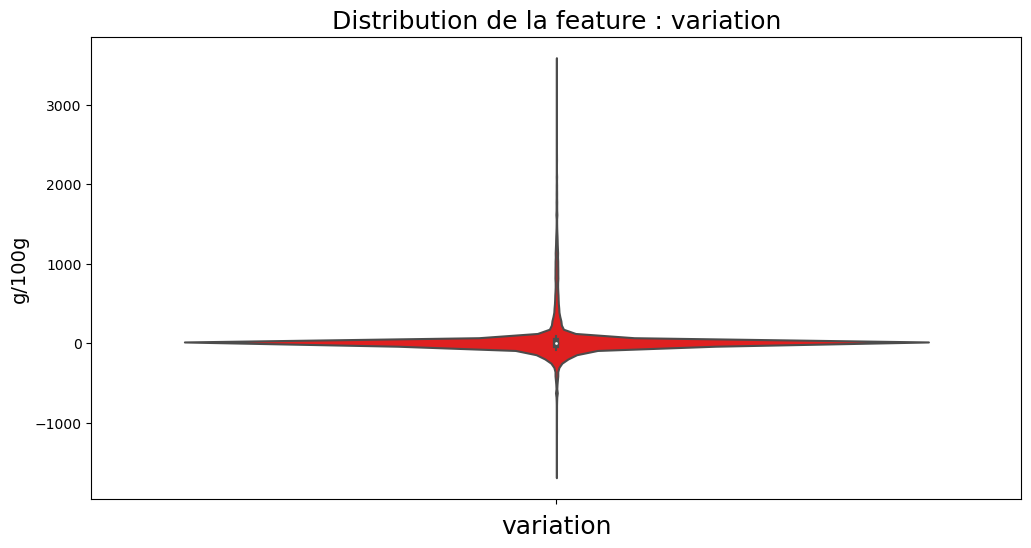

In [98]:
figure_feature(dif, "variation")

L'alcool pourrait contribuer à sous-estimer l'énergie.

1 g d'alcool équivaut à 29.3kJ.


In [99]:
data.loc[(data["alcohol_100g"].notnull()) & (data["alcohol_100g"]>0), ['energy_100g','fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g',"alcohol_100g"]]

,energy_100g,fat_100g,carbohydrates_100g,proteins_100g,salt_100g,alcohol_100g
98811,832.0,NaN,NaN,NaN,NaN,36.0
98812,856.0,NaN,NaN,NaN,NaN,37.5
98813,860.0,NaN,NaN,NaN,NaN,37.5
98921,169.0,NaN,2.94,0.361,NaN,5.0
99172,145.0,0.0,10.60,1.300,NaN,5.0
...,...,...,...,...,...,...
255235,276.0,NaN,NaN,7.000,NaN,7.0
255236,276.0,NaN,NaN,7.000,NaN,7.0
255745,2775.0,58.0,13.00,21.000,0.55,12.0
255746,2775.0,58.0,13.00,21.000,0.55,12.0


In [100]:
dt.loc[(dt["alcohol_100g"].notnull()) & (dt["alcohol_100g"]>0), ['energy_100g','fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g',"alcohol_100g"]]

,energy_100g,fat_100g,carbohydrates_100g,proteins_100g,salt_100g,alcohol_100g
99172,198.7300,0.0,10.60,1.300,NaN,5.0
100207,68.7038,0.0,3.82,0.294,0.00,4.7
117617,27.8556,0.0,1.39,0.278,NaN,4.2
155501,165.3300,0.0,9.90,0.000,0.01,0.1
155732,165.3300,0.0,9.90,0.000,0.01,0.1
...,...,...,...,...,...,...
252574,80.1600,0.0,4.00,0.800,NaN,8.0
252575,80.1600,0.0,4.00,0.800,NaN,8.0
255745,2754.4000,58.0,13.00,21.000,0.55,12.0
255746,2754.4000,58.0,13.00,21.000,0.55,12.0


C:\Users\33664\anaconda3\lib\site-packages\seaborn\_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


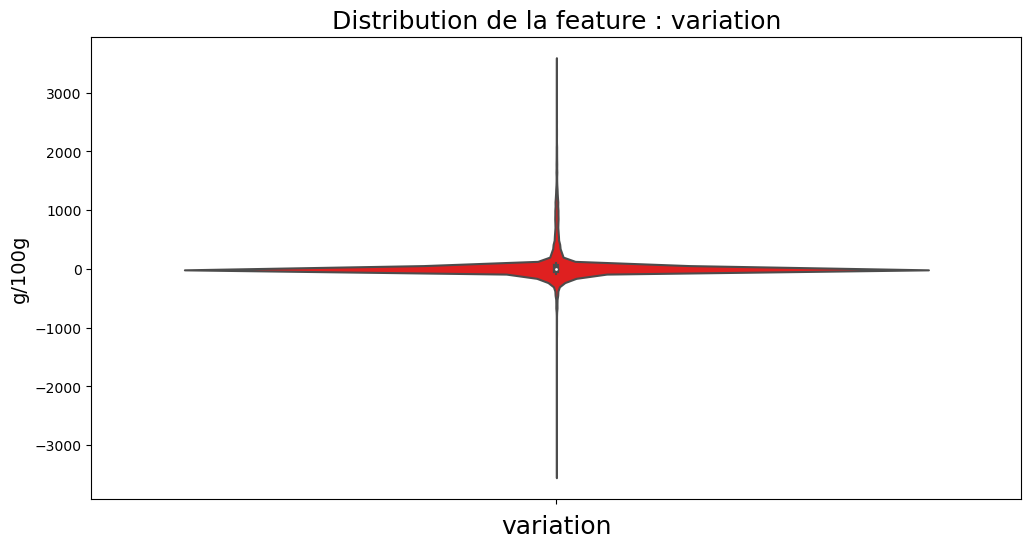

In [101]:
# On prend un slice du dataframe
dt_alcool = copy.deepcopy(data[cond1 & cond2])

dt_alcool["energy_100g"] =( 
[(x[0]*37.7 if x[0] > 0 else 0) 
 + (x[1]*16.7 if x[1] > 0 else 0) 
 + (x[2]*16.7 if x[2] > 0 else 0) 
 + (x[3]*29.3 if x[3] > 0 else 0) 
 for x in np.array(dt_alcool[macro_nrj + ["alcohol_100g"]])])
    
#On mesure la différence entre la valeur de la base de données et la valeur calculée
dif_alcool = pd.DataFrame({"variation" : data[cond1 & cond2]["energy_100g"] - dt_alcool["energy_100g"]})

figure_feature(dif_alcool, "variation")

In [102]:
dt_alcool.loc[(dt_alcool["alcohol_100g"].notnull()) & (dt_alcool["alcohol_100g"]>0), ['energy_100g','fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g',"alcohol_100g"]]


,energy_100g,fat_100g,carbohydrates_100g,proteins_100g,salt_100g,alcohol_100g
99172,345.2300,0.0,10.60,1.300,NaN,5.0
100207,206.4138,0.0,3.82,0.294,0.00,4.7
117617,150.9156,0.0,1.39,0.278,NaN,4.2
155501,168.2600,0.0,9.90,0.000,0.01,0.1
155732,168.2600,0.0,9.90,0.000,0.01,0.1
...,...,...,...,...,...,...
252574,314.5600,0.0,4.00,0.800,NaN,8.0
252575,314.5600,0.0,4.00,0.800,NaN,8.0
255745,3106.0000,58.0,13.00,21.000,0.55,12.0
255746,3106.0000,58.0,13.00,21.000,0.55,12.0


In [103]:
display(data["energy_100g"].describe())
display(dt["energy_100g"].describe())
display(dt_alcool["energy_100g"].describe())
display(dif["variation"].describe())
display(dif_alcool["variation"].describe())

count    247342.000000
mean       1130.224349
std         785.999757
min           0.000000
25%         393.000000
50%        1109.000000
75%        1674.000000
max        3889.238000
Name: energy_100g, dtype: float64

count    241645.000000
mean       1102.381055
std         790.199414
min           0.000000
25%         360.490000
50%        1062.099000
75%        1666.989000
max        3889.238000
Name: energy_100g, dtype: float64

count    241645.000000
mean       1102.557402
std         790.135542
min           0.000000
25%         360.720000
50%        1062.240000
75%        1667.050000
max        4500.060000
Name: energy_100g, dtype: float64

count    241645.000000
mean         32.667095
std         228.458093
min       -1655.810000
25%         -17.536000
50%           1.803000
75%          27.240000
max        3556.000000
Name: variation, dtype: float64

count    241645.000000
mean         32.490749
std         228.444757
min       -3515.960000
25%         -17.619000
50%           1.778000
75%          27.140000
max        3556.000000
Name: variation, dtype: float64

In [104]:
data[cond1 & cond2]["energy_100g"]

0         2243.0
1         1941.0
2         2540.0
3         1552.0
4         1933.0
           ...  
255946     247.0
255947    1538.0
255948    1538.0
255949    2155.0
255950    2155.0
Name: energy_100g, Length: 241645, dtype: float64

In [105]:
dt["energy_100g"]

0         2210.351
1         1985.441
2         2750.702
3         1485.268
4         1973.343
            ...   
255946     294.755
255947    1628.490
255948    1628.490
255949     382.020
255950     382.020
Name: energy_100g, Length: 241645, dtype: float64

In [106]:
result_test1 = stats.ttest_rel(data.loc[cond1 & cond2,"energy_100g"], dt["energy_100g"], nan_policy = "omit")
display(result_test1)
result_test2 = stats.ttest_rel(dt["energy_100g"], dt_alcool["energy_100g"])
display(result_test2)
result_test1 = stats.ttest_rel(data.loc[cond1 & cond2,"energy_100g"], dt_alcool["energy_100g"], nan_policy = "omit")
display(result_test1)

Ttest_relResult(statistic=70.28989247168724, pvalue=0.0)

Ttest_relResult(statistic=-6.724993267608909, pvalue=1.759888045622314e-11)

Ttest_relResult(statistic=69.91452768533482, pvalue=0.0)

Ces résultats montrent que la différence entre l'energie théorique et mesurée est significative.

L'ajout de la l'alcool dans la mesure de l'energie est significatif par rapport à la valeur donnée et la valeur mesurée sans alcool.

Les valeurs médianes et interquartiles ne sont pas altérées.

Il y a juste des valeurs extrèmes qui devront être rectifiées.

On réactualise notre fonction.

In [107]:
## Fonction pour calculer l'énergie
## V2
def energy_calcul(df):

    energy = ['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'alcohol_100g']
    dt_mesure = [(x[0]*37.7 if x[0] > 0 else 0) 
 + (x[1]*16.7 if x[1] > 0 else 0) 
 + (x[2]*16.7 if x[2] > 0 else 0) 
 + (x[3]*29.3 if x[3] > 0 else 0) 
 for x in np.array(df[energy])]
    
    cond1 = (df["energy_100g"].isnull()) # Si la valeur est nulle
    cond2 = (df["energy_100g"] < df["energy-from-fat_100g"]) # si la valeur est aberrante
    cond3 = (df["energy_100g"] > 3770) # Quand valeur supérieure au maximum théoorique
    cond4 = (df["energy_100g"] == 0) # Quand valeur = 0, on recalcul
    cond5 = (abs(df["energy_100g"] - dt_mesure) > 500) # Quand difference > 500
    cond6 = (df[energy].count(axis = 1) >= 3) # quand on a au moins 3 mesures
    cond_final = (df[energy].sum(axis = 1) > 0) # Si la valeur est mesurable

 
    mask = copy.deepcopy(df)
    
    print("Nombre de valeurs aberrantes ", df[(cond1|cond2|cond3|cond4|cond5)].shape[0])
    print("null : ", df[cond1].shape[0],
         "<Nfat : ", df[cond2].shape[0],
         ">3770 : ", df[cond3].shape[0],
         "==0 : ", df[cond4].shape[0],
         "diff > 500 : ", df[cond5].shape[0],
         "\n")
    print("Nombre de valeurs qui seront corrigées ", df[(cond1|cond2|cond3|cond4|(cond5 & cond6)) & cond_final].shape[0])
    print("null : ", df[cond1 & cond_final].shape[0],
         "<Nfat : ", df[cond2 & cond_final].shape[0],
         ">3770 : ", df[cond3 & cond_final].shape[0],
         "==0 : ", df[cond4 & cond_final].shape[0],
         "diff > 500 : ", df[(cond5 & cond6) & cond_final].shape[0],
         "\n")
    print("Nombre de valeurs qui resteront non-corrigées ", df[(cond1|cond2|cond3|cond4|(cond5 & cond6)) & ~cond_final].shape[0])
    print("null : ", df[cond1 & ~cond_final].shape[0],
         "<Nfat : ", df[cond2 & ~cond_final].shape[0],
         ">3770 : ", df[cond3 & ~cond_final].shape[0],
         "==0 : ", df[cond4 & ~cond_final].shape[0],
         "diff > 500 : ", df[(cond5 & cond6) & ~cond_final].shape[0],
         "\n")
    
    df.loc[(cond1|cond2|cond3|cond4|(cond5 & cond6)) & cond_final, "energy_100g"] =( 
[(x[0]*37.7 if x[0] > 0 else 0) 
 + (x[1]*16.7 if x[1] > 0 else 0) 
 + (x[2]*16.7 if x[2] > 0 else 0) 
 + (x[3]*29.3 if x[3] > 0 else 0) 
 for x in np.array(df.loc[(cond1|cond2|cond3|cond4|(cond5 & cond6)) & cond_final, energy])])
    
    df.loc[df["energy_100g"] >3770, "energy_100g"] = 3770 
    # Test statistique
    resultcorrection_ttest(mask, df, "energy_100g", False)
    
    print("Nombre de valeurs nulles restantes ", df[cond1].shape[0])
    
    return df

Nombre de valeurs aberrantes  16759
null :  0 <Nfat :  0 >3770 :  956 ==0 :  6180 diff > 500 :  9623 

Nombre de valeurs qui seront corrigées  9384
null :  0 <Nfat :  0 >3770 :  956 ==0 :  2 diff > 500 :  8426 

Nombre de valeurs qui resteront non-corrigées  6585
null :  0 <Nfat :  0 >3770 :  0 ==0 :  6178 diff > 500 :  407 

energy_100g : la modification change drastiquement les données, p_value: 1.569375258208576e-36


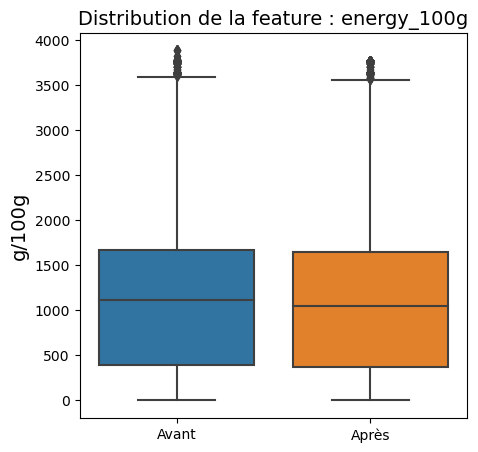

Calcul du coefficient de variation :
Avant traitement =  69.54369348340933
Après traitement =  70.82129395613997
Nombre de valeurs nulles restantes  0


In [108]:
data = energy_calcul(data)

C:\Users\33664\anaconda3\lib\site-packages\seaborn\_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


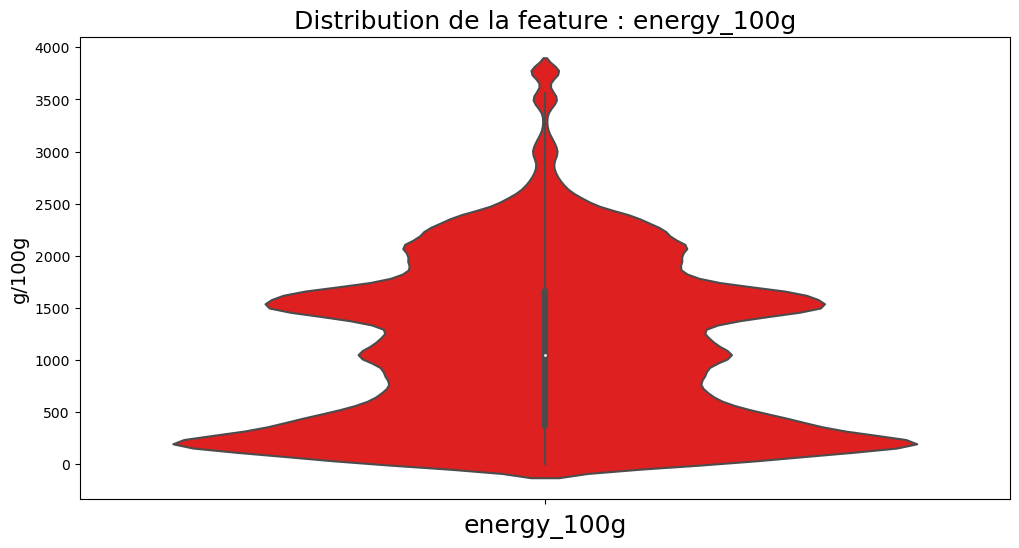

In [109]:
figure_feature(data, "energy_100g")

La distribution de l'energy est toujours similaire, mais comme le test le montre, la modification est significative, c'est en accord avec les résultats précédents.

Nous n'avons plus de valeurs nulles pour l'énergie.

In [110]:
# Fonction permettant de créer le fichier csv

def creation_fichier_csv(df,nom_du_fichier):
    
    ## On identifie si le format CSV a été entré, sinon on l'ajout
    if ".csv" not in nom_du_fichier:
        nom_du_fichier = nom_du_fichier + ".csv"
        
    ## Le fichier est écrit au même endroit que le notebook
    ## Séparateur : tab
    df.to_csv(nom_du_fichier, index = False, sep = "\t")


Nous avons donc des données nettoyées, qu'on peut exporter et ensuite analyser.

In [111]:
creation_fichier_csv(data, "donnees_nettoyees")

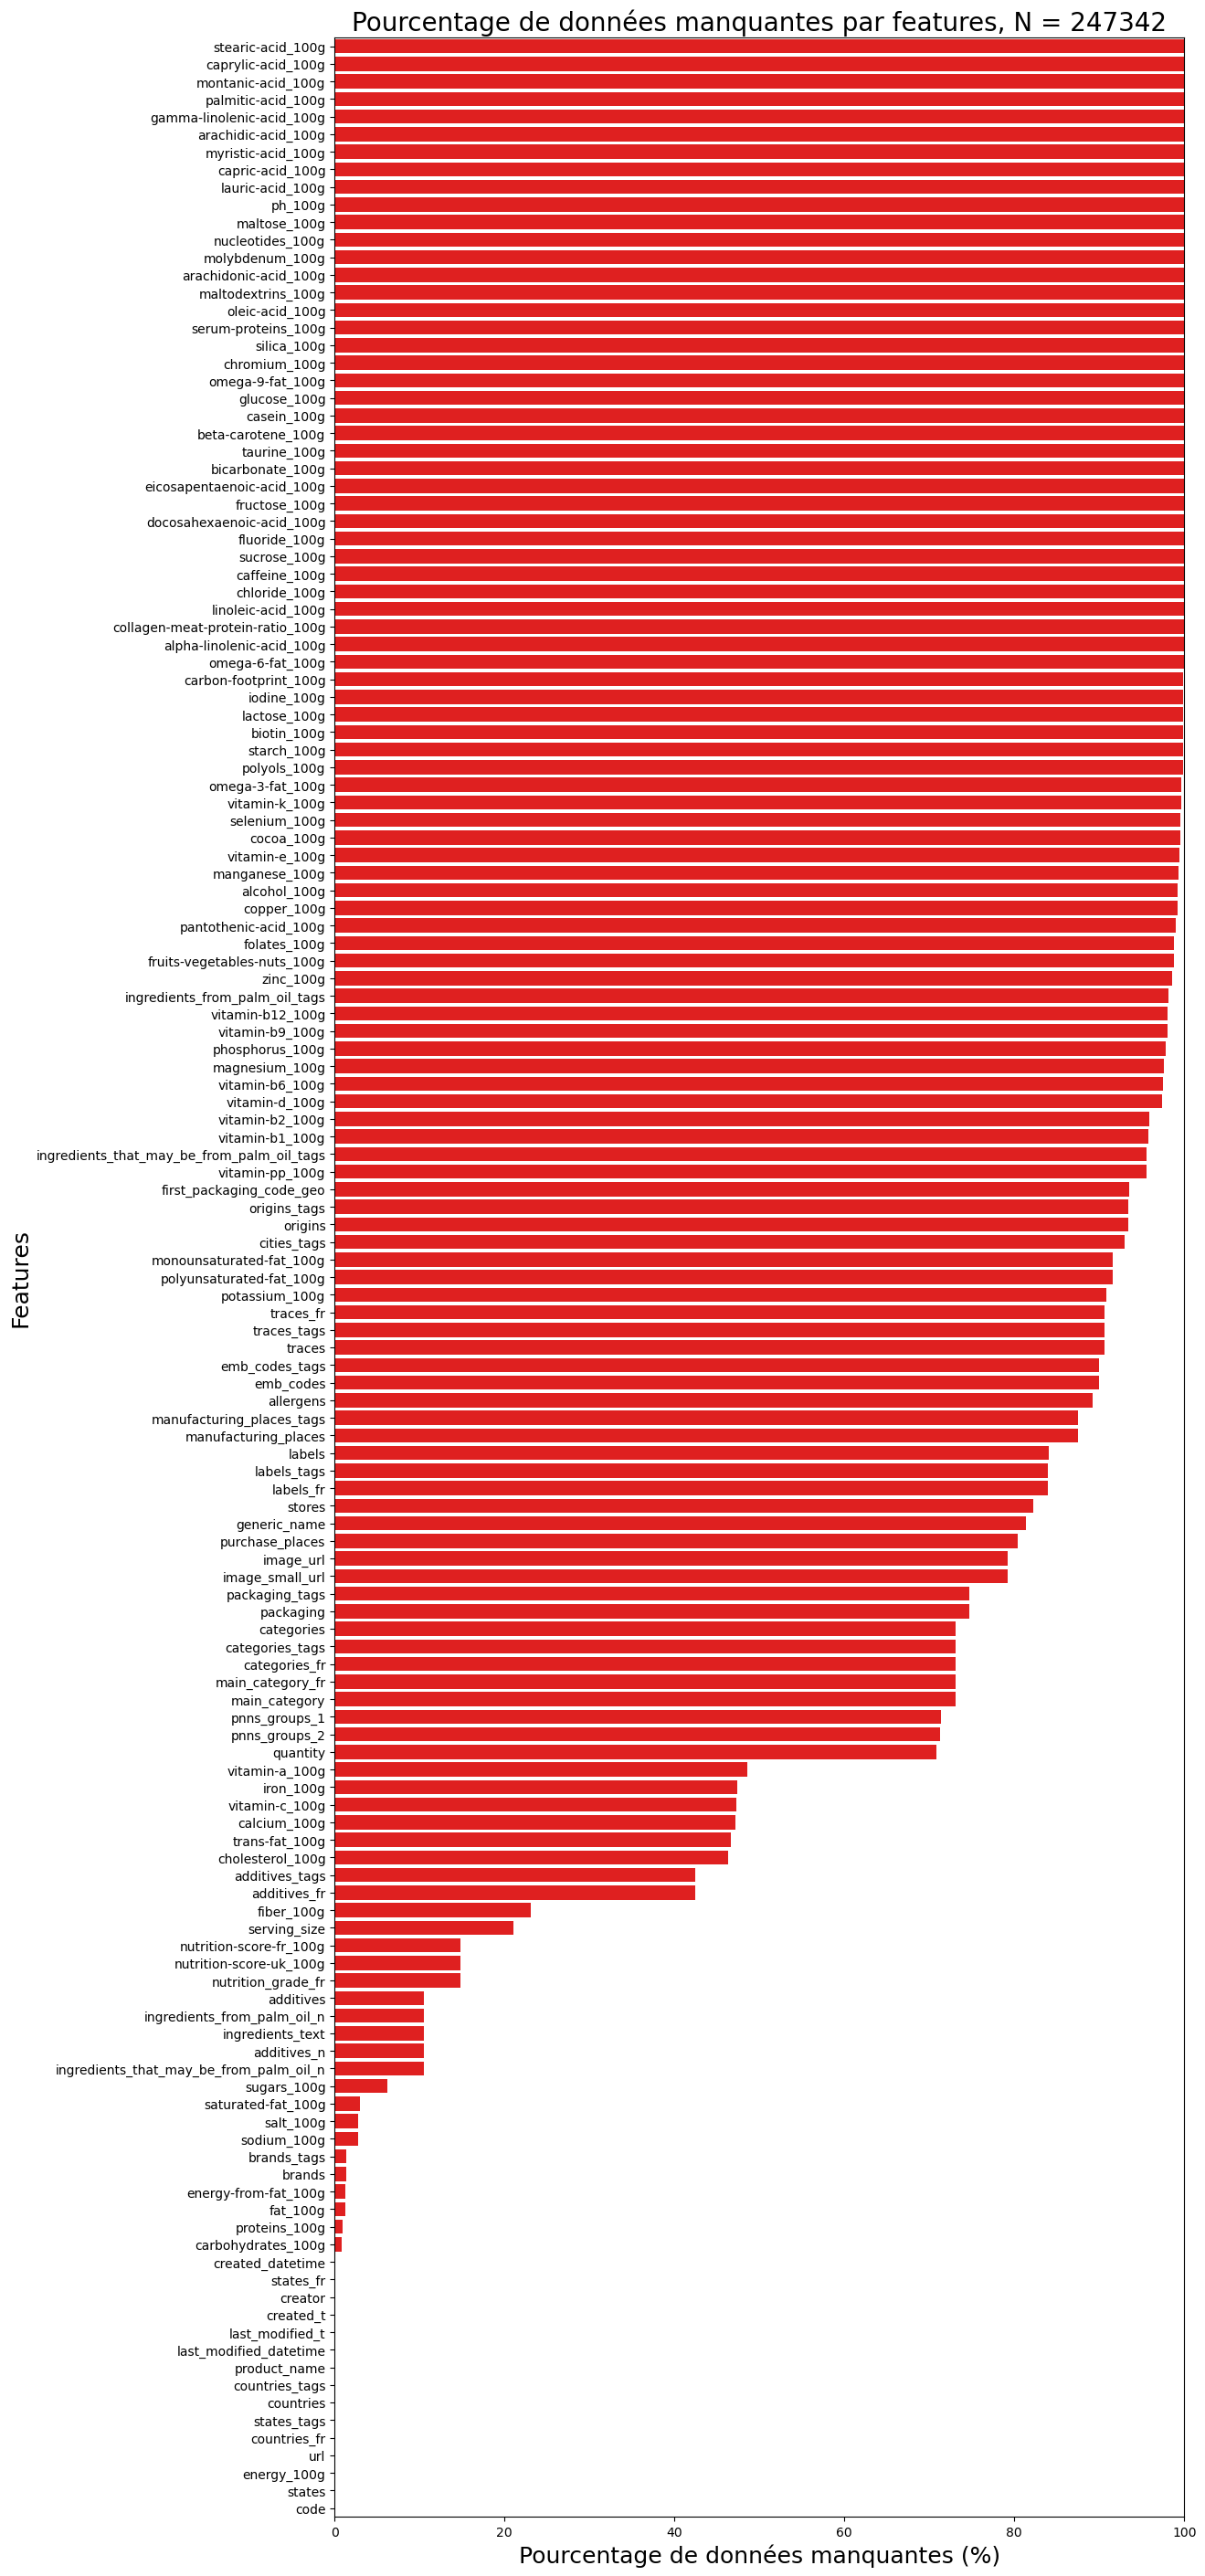

In [112]:
valeurs_manquantes_graph(data,'column')